# Projet 7: Etablir un modèle de scoring

## Chargement Package

In [1]:
# Général
import numpy as np
import pandas as pd
import joblib
import gc
import time
from contextlib import contextmanager
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_row', 250)
pd.set_option('display.max_column', 200)

# Modélisation - Preprocessing
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.feature_selection import RFE
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline as mp1
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from imblearn.pipeline import make_pipeline as mp2
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN

# Modélisation - Model
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.linear_model import BayesianRidge, LinearRegression, LogisticRegression

# Modélisation - Metrics
from sklearn.metrics import confusion_matrix, fbeta_score, f1_score
from sklearn.metrics import make_scorer, roc_auc_score

# Modélisation - Grille de recherche
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
from hyperopt.pyll.base import scope

## Chargements des différents datasets

In [2]:
app_test = pd.read_csv(r'application_test.csv')

In [3]:
app_train = pd.read_csv(r'application_train.csv')

In [4]:
bureau = pd.read_csv(r'bureau.csv')

In [5]:
bureau_balance = pd.read_csv(r'bureau_balance.csv')

In [6]:
credit_card_balance = pd.read_csv(r'credit_card_balance.csv')

In [7]:
installments_payments = pd.read_csv(r'installments_payments.csv')

In [8]:
POS_CASH_balance = pd.read_csv(r'POS_CASH_balance.csv')

In [9]:
previous_application = pd.read_csv(r'previous_application.csv')

In [10]:
hc_description = pd.read_csv(r'HomeCredit_columns_description.csv')

## HomeCredit : Définitions des types de features

In [11]:
hc_description.shape

(219, 5)

In [12]:
print(hc_description[hc_description['Row']=='TARGET']['Description'])

1    Target variable (1 - client with payment diffi...
Name: Description, dtype: object


In [13]:
# Colonnes de applications et test
hc_description[hc_description['Table']=='application_{train|test}.csv'][['Row', 'Description']]

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,Target variable (1 - client with payment diffi...
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
5,FLAG_OWN_REALTY,Flag if client owns a house or flat
6,CNT_CHILDREN,Number of children the client has
7,AMT_INCOME_TOTAL,Income of the client
8,AMT_CREDIT,Credit amount of the loan
9,AMT_ANNUITY,Loan annuity


In [14]:
# Colonnes de bureau
hc_description[hc_description['Table']=='bureau.csv'][['Row', 'Description']]

,Row,Description
122,SK_ID_CURR,ID of loan in our sample - one loan in our sam...
123,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit re...
124,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits
125,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit
126,DAYS_CREDIT,How many days before current application did c...
127,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the ti...
128,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at t...
129,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of appl...
130,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau cr...
131,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit pr...


In [15]:
# Colonnes de bureau balance
hc_description[hc_description['Table']=='bureau_balance.csv'][['Row', 'Description']]

,Row,Description
139,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique cod...
140,MONTHS_BALANCE,Month of balance relative to application date ...
141,STATUS,Status of Credit Bureau loan during the month ...


In [16]:
# Colonnes de POS_CASH
hc_description[hc_description['Table']=='POS_CASH_balance.csv'][['Row', 'Description']]

,Row,Description
142,SK_ID_PREV,ID of previous credit in Home Credit related t...
143,SK_ID_CURR,ID of loan in our sample
144,MONTHS_BALANCE,Month of balance relative to application date ...
145,CNT_INSTALMENT,Term of previous credit (can change over time)
146,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit
147,NAME_CONTRACT_STATUS,Contract status during the month
148,SK_DPD,DPD (days past due) during the month of previo...
149,SK_DPD_DEF,DPD during the month with tolerance (debts wit...


In [17]:
# Colonnes de credit_card_balance
hc_description[hc_description['Table']=='credit_card_balance.csv'][['Row', 'Description']]

,Row,Description
150,SK_ID_PREV,ID of previous credit in Home credit related t...
151,SK_ID_CURR,ID of loan in our sample
152,MONTHS_BALANCE,Month of balance relative to application date ...
153,AMT_BALANCE,Balance during the month of previous credit
154,AMT_CREDIT_LIMIT_ACTUAL,Credit card limit during the month of the prev...
155,AMT_DRAWINGS_ATM_CURRENT,Amount drawing at ATM during the month of the ...
156,AMT_DRAWINGS_CURRENT,Amount drawing during the month of the previou...
157,AMT_DRAWINGS_OTHER_CURRENT,Amount of other drawings during the month of t...
158,AMT_DRAWINGS_POS_CURRENT,Amount drawing or buying goods during the mont...
159,AMT_INST_MIN_REGULARITY,Minimal installment for this month of the prev...


In [18]:
# Colonnes de previous application
hc_description[hc_description['Table']=='previous_application.csv'][['Row', 'Description']]

,Row,Description
173,SK_ID_PREV,ID of previous credit in Home credit related t...
174,SK_ID_CURR,ID of loan in our sample
175,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loa..."
176,AMT_ANNUITY,Annuity of previous application
177,AMT_APPLICATION,For how much credit did client ask on the prev...
178,AMT_CREDIT,Final credit amount on the previous applicatio...
179,AMT_DOWN_PAYMENT,Down payment on the previous application
180,AMT_GOODS_PRICE,Goods price of good that client asked for (if ...
181,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply ...
182,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client ...


In [19]:
# Colonnes de installments payments
hc_description[hc_description['Table']=='installments_payments.csv'][['Row', 'Description']]

,Row,Description
211,SK_ID_PREV,ID of previous credit in Home credit related t...
212,SK_ID_CURR,ID of loan in our sample
213,NUM_INSTALMENT_VERSION,Version of installment calendar (0 is for cred...
214,NUM_INSTALMENT_NUMBER,On which installment we observe payment
215,DAYS_INSTALMENT,When the installment of previous credit was su...
216,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...
217,AMT_INSTALMENT,What was the prescribed installment amount of ...
218,AMT_PAYMENT,What the client actually paid on previous cred...


In [20]:
# Définition des variables catégorielles et des variables numériques
id_col = ['SK_ID_CURR', 'SK_ID_PREV', 'SK_BUREAU_ID']

# numerical et categorerical colonnes for application.csv
categorial_col_app_train = ['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
                  'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
                  'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
                  'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
                  'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
                  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_WORK_CITY',
                  'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 
                  'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'FONDKAPREMONT_MODE',
                  'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 
                  'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
                  'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
                  'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
                  'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']
categorial_col_app_test = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
                  'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
                  'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
                  'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
                  'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
                  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_WORK_CITY',
                  'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 
                  'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'FONDKAPREMONT_MODE',
                  'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 
                  'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
                  'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
                  'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
                  'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']
numeric_col_app = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_ANNUITY',
               'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
               'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
               'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
               'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 
               'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
               'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
               'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
               'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
               'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 
               'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI','BASEMENTAREA_MEDI',
               'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
               'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
               'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 
               'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 
               'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
               'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 
               'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
               'AMT_REQ_CREDIT_BUREAU_YEAR' ]

# numerical et categorerical colonnes for bureau.csv
categorial_col_b = ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
numeric_col_b = ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT',
                 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
                 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY']

# numerical et categorerical colonnes for bureau_balance.csv
categorial_col_bb = ['STATUS']
numeric_col_bb = ['MONTHS_BALANCE']

# numerical et categorerical colonnes for POS_CASH_balance.csv
categorial_col_pcb = ['NAME_CONTRACT_STATUS']
numeric_col_pcb = ['MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE',
                   'SK_DPD', 'SK_DPD_DEF']

# numerical et categorerical colonnes for credit_card_balance.csv
categorial_col_ccb = ['NAME_CONTRACT_STATUS']
numeric_col_ccb = ['MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
                   'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT',
                   'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 
                   'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
                   'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 
                   'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM',
                   'SK_DPD', 'SK_DPD_DEF']

# numerical et categorerical colonnes for previous_application.csv
categorial_col_pa = ['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
                     'NFLAG_LAST_APPL_IN_DAY', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE',
                     'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE',
                     'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
                     'CHANNEL_TYPE',  'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 
                     'NFLAG_INSURED_ON_APPROVAL']
numeric_col_pa = ['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
                  'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED',
                  'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 
                  'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE','DAYS_TERMINATION']

# numerical et categorerical colonnes for installments_payments.csv
categorial_col_ip = ['NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER']
numeric_col_ip = ['DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
                  'AMT_INSTALMENT', 'AMT_PAYMENT']

## Chargement de fonctions

### Preprocessing

In [21]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, categorical_columns, nan_as_category = True):
    original_columns = list(df.columns)
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [38]:
# NaN imputation using iterative imputer
def iimputer(df, model='LinearRegression', max_iter=10, tol=0.01):
    
    model_dic={'LinearRegression': LinearRegression(),
               'BayesianRidge': BayesianRidge(),
               'RandomForestRegressor': RandomForestRegressor()}

    # Definition of iterative imputer
    iim=IterativeImputer(estimator=model_dic[model],
                         initial_strategy='median',
                         max_iter=max_iter,
                         tol=tol,
                         missing_values=np.nan,
                         skip_complete=True)
    
    # impute all the numeric columns containing missing values
    imputed_df = pd.DataFrame(iim.fit_transform(df), index=df.index, columns=df.columns)
    
    return imputed_df

In [39]:
def add_poly_feat(df, features=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], degree=3):

    # Create the polynomial object with specified degree
    poly_transformer = PolynomialFeatures(degree=degree)
    poly_transformer.fit(df[features])

    # Transform the features
    poly_features = poly_transformer.transform(df[features])
    print('Polynomial Features shape: ', poly_features.shape)

    # Create a dataframe of the features
    poly_features_columns = poly_transformer.get_feature_names(features)
    poly_features = pd.DataFrame(poly_features, columns = poly_features_columns)
    poly_features.columns = pd.Index(['NEW_' + e[0] + "_" + e[1].upper() for e in poly_features.columns.tolist()])
    df[poly_features_columns] = poly_features

    return df

In [40]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(df=app_train, test_df=app_test,
                           cat_col=categorial_col_app_test,
                           nan_as_category=True):
    # Read data
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    
    # Merge df and test_df
    df = df.append(test_df).reset_index(drop=True)
    print("Dataframe shape after merge: {}".format(df.shape))
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan 
    # and 'XNA' -> Nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    df = df.replace('XNA', np.nan)
    
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, categorical_columns=cat_col,
                                   nan_as_category=nan_as_category)

    print("Dataframe shape after one hot encoding: {}".format(df.shape))

    # Features engineering
    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / (0.1 + df['AMT_ANNUITY'])
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / (0.1 + df['AMT_GOODS_PRICE'])
    df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (0.1 + df['CNT_CHILDREN'])
    df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / (0.1 + df['DAYS_BIRTH'])
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (0.1 + df['AMT_INCOME_TOTAL'])
    df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
    df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / (0.1 + df['DAYS_BIRTH'])
    df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / (0.1 + df['DAYS_EMPLOYED'])
    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / (0.1 + df['DAYS_BIRTH'])
    df['NEW_PHONE_TO_EMPLOYED_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / (0.1 + df['DAYS_EMPLOYED'])
    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / (0.1 + df['AMT_INCOME_TOTAL'])
    
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / (0.1 + df['DAYS_BIRTH'])
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / (0.1 + df['AMT_CREDIT'])
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / (0.1 + df['CNT_FAM_MEMBERS'])
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / (0.1 + df['AMT_INCOME_TOTAL'])
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / (0.1 + df['AMT_CREDIT'])
    
    print("Dataframe shape after feature engineering: {}".format(df.shape))
    
    # Iterative Imputer of NaN
#    train_df = df[df['TARGET'].notnull()]
#    test_df = df[df['TARGET'].isnull()]

    num_cols = df.drop(columns=cat_cols + ['TARGET', 'SK_ID_CURR']).columns.to_list()
    #print("Feature NaN before imputing: {}".format(df[num_cols].isna().sum().sum()))
#     df_train_1=iimputer(train_df[num_cols])
#     train_df[num_cols] = df_train_1
    
#     df_test_1=iimputer(test_df[num_cols])
#     test_df[num_cols] = df_test_1
    #print("Feature NaN after imputing: {}".format(df[num_cols].isna().sum().sum()))
    
    # StandardScaler
#     std = StandardScaler()
#     np_num_train = std.fit_transform(train_df[num_cols])
#     train_df[num_cols] = pd.DataFrame(np_num_train, columns=num_cols)
    
#     np_num_test = std.fit_transform(test_df[num_cols])
#     test_df[num_cols] = pd.DataFrame(np_num_test, columns=num_cols)
    
#     train_df.append(test_df).reset_index(drop=True)  

    del test_df
    gc.collect()
    return df, num_cols, cat_cols

In [41]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(bureau=bureau, bb=bureau_balance,
                       cat_col_b=categorial_col_b, cat_col_bb=categorial_col_bb,
                       nan_as_category = True):
    
    # Read data
    print("Bureau shape: {}, Bureau Balance shape: {}".format(bureau.shape, bb.shape))
    
    # NaN imputation
    bureau = bureau.replace('XNA', np.nan)
    bb = bb.replace('XNA', np.nan)
    
    # One Hot Encoding des variables catégorielles
    bb, bb_cat = one_hot_encoder(bb, categorical_columns=cat_col_bb,
                                 nan_as_category=nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, categorical_columns=cat_col_b,
                                         nan_as_category=nan_as_category)

    # Groupby de bureau balance sur SK_ID_BUREAU
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bb_agg_cat = [col_1 for col_1 in bb_agg.columns for col_2 in bb_cat if col_2 in col_1]
    bb_agg_num = bb_agg.drop(columns=bb_agg_cat).columns.to_list()
    print("Bureau balance après agrégation selon SK_ID_BUREAU")
    display(bb_agg.head(3))

    # Merge de bureau et bureau balance
    bureau = bureau.merge(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    print(f"Bureau shape après merge : {bureau.shape}")
    display(bureau.head(3))
    del bb, bb_agg
    gc.collect()
    
    # Groupby sur SK_ID_CURR
    num_aggregations = {
        'DAYS_CREDIT': ['mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    bureau_agg_cat = [col_1 for col_1 in bureau_agg.columns for col_2 in cat_aggregations.keys() if col_2 in col_1]
    bureau_agg_num = bureau_agg.drop(columns=bureau_agg_cat).columns.to_list()
    print(f"Bureau après agrégation selon SK_ID_CURR : shape {bureau_agg.shape}")
    print(f"Nombres de variables numériques après agrégation: {len(bureau_agg_num)}")
    print(f"Nombres de variables catégorielles après agrégation: {len(bureau_agg_cat)}")
    
    display(bureau_agg.head(3))
    del bureau
    gc.collect()

    # Imputing des valeurs numériques
    print(f"Features NaN avant imputing : {bureau_agg.isna().sum().sum()}")
    print(f"Num Features NaN avant imputing : {bureau_agg[bureau_agg_num].isna().sum().sum()}")
    imputed_bur = iimputer(bureau_agg[bureau_agg_num], max_iter=20, tol=0.01)
    print(f"Num Features NaN après imputing : {imputed_bur.isna().sum().sum()}")
    
#     # Standard Scaling sur les valeurs numériques
#     std = StandardScaler()
#     np_num = std.fit_transform(imputed_bur)
#     bg_num=pd.DataFrame(np_num, index=bureau_agg[bureau_agg_num].index, columns=bureau_agg_num)
#     bureau_agg[bureau_agg_num]=bg_num
#     print(f"Num Features NaN après imputing & stdscaler : {bureau_agg[bureau_agg_num].isna().sum().sum()}")

#     # Imputing des valeurs catégorielles
#     print(f"Cat Features NaN avant imputing : {bureau_agg[bureau_agg_cat].isna().sum().sum()}")
#     bureau_agg[bureau_agg_cat] = bureau_agg[bureau_agg_cat].fillna(0)
#     print(f"Cat Features NaN après imputing : {bureau_agg[bureau_agg_cat].isna().sum().sum()}")

#     print(f"Features NaN après imputing : {bureau_agg.isna().sum().sum()}")
    
    return bureau_agg, bureau_agg_num, bureau_agg_cat

In [42]:
# Preprocess previous_applications.csv
def previous_applications(prev=previous_application,
                          cat_col_pa=categorial_col_pa,
                          nan_as_category=True):
    
    # Read data
    print("Previous applications shape: {}".format(prev.shape))
    
    # NaN imputation
    prev = prev.replace('XNA', np.nan)
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
       
    # One Hot Encoding of categorial features
    prev, cat_cols = one_hot_encoder(prev, categorical_columns=cat_col_pa,
                                     nan_as_category=nan_as_category)
        
    # Feature Engineering: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / (0.1 + prev['AMT_CREDIT'])

    # Groupby sur SK_ID_CURR - numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['max', 'mean'],
        'AMT_APPLICATION': ['min', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'RATE_INTEREST_PRIMARY': ['min', 'max', 'mean'],
        'RATE_INTEREST_PRIVILEGED': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'SELLERPLACE_AREA': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        'DAYS_FIRST_DRAWING': ['min', 'max', 'mean'],
        'DAYS_FIRST_DUE': ['min', 'max', 'mean'],
        'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
        'DAYS_LAST_DUE': ['min', 'max', 'mean'],
        'DAYS_TERMINATION': ['min', 'max', 'mean']
    }

    # Groupby sur SK_ID_CURR - categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    prev_agg_cat = [col_1 for col_1 in prev_agg.columns for col_2 in cat_aggregations.keys() if col_2 in col_1]
    prev_agg_num = prev_agg.drop(columns=prev_agg_cat).columns.to_list()
    print(f"Previous applications après agrégation selon SK_ID_CURR : shape {prev_agg.shape}")
    print(f"Nombres de variables numériques après agrégation: {len(prev_agg_num)}")
    print(f"Nombres de variables catégorielles après agrégation: {len(prev_agg_cat)}")
    display(prev_agg.head(3))
 
     # Imputing des valeurs numériques
    print(f"Features NaN avant imputing : {prev_agg.isna().sum().sum()}")
    print(f"Num Features NaN avant imputing : {prev_agg[prev_agg_num].isna().sum().sum()}")
    imputed_prev = iimputer(prev_agg[prev_agg_num], max_iter=20, tol=0.01)
    print(f"Num Features NaN après imputing : {imputed_prev.isna().sum().sum()}")
    
#     # Standard Scaling sur les valeurs numériques
#     std = StandardScaler()
#     np_num = std.fit_transform(imputed_prev)
#     prev_num=pd.DataFrame(np_num, index=prev_agg[prev_agg_num].index, columns=prev_agg_num)
#     prev_agg[prev_agg_num]=prev_num
#     print(f"Num Features NaN après imputing & stdscaler : {prev_agg[prev_agg_num].isna().sum().sum()}")

#     # Imputing des valeurs catégorielles
#     print(f"Cat Features NaN avant imputing : {prev_agg[prev_agg_cat].isna().sum().sum()}")
#     prev_agg[prev_agg_cat] = prev_agg[prev_agg_cat].fillna(0)
#     print(f"Cat Features NaN après imputing : {prev_agg[prev_agg_cat].isna().sum().sum()}")

#     print(f"Features NaN après imputing : {prev_agg.isna().sum().sum()}")

    return prev_agg, prev_agg_num, prev_agg_cat

In [43]:
# Preprocess POS_CASH_balance.csv
def pos_cash(pos=POS_CASH_balance,
             cat_col_pcb=categorial_col_pcb,
             nan_as_category=True):
    
    # Read data
    print("POS CASH balance shape: {}".format(pos.shape))
    
    # NaN imputation
    pos = pos.replace('XNA', np.nan)
    
    # One Hot Encoding of categorial features
    pos, cat_cols = one_hot_encoder(pos, categorical_columns=cat_col_pcb,
                                    nan_as_category=nan_as_category)
    
    # Groupby sur SK_ID_CURR - numeric features
    num_aggregations = {
        'MONTHS_BALANCE': ['min', 'max', 'mean'],
        'CNT_INSTALMENT': ['min', 'max', 'mean'],
        'CNT_INSTALMENT_FUTURE': ['min', 'max', 'mean'],
        'SK_DPD': ['min', 'max', 'mean'],
        'SK_DPD_DEF': ['min', 'max', 'mean']}

    # Groupby sur SK_ID_CURR - categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    
    # Groupby sur SK_ID_CURR - Ajout Count pos cash accounts
    pos_agg['COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    pos_agg_cat = [col_1 for col_1 in pos_agg.columns for col_2 in cat_aggregations.keys() if col_2 in col_1]
    pos_agg_num = pos_agg.drop(columns=pos_agg_cat).columns.to_list()
    print(f"POS CASH balance après agrégation selon SK_ID_CURR : shape {pos_agg.shape}")
    print(f"Nombres de variables numériques après agrégation: {len(pos_agg_num)}")
    print(f"Nombres de variables catégorielles après agrégation: {len(pos_agg_cat)}")
    display(pos_agg.head(3))
    del pos
    gc.collect()

    # Imputing des valeurs numériques
    print(f"Features NaN avant imputing : {pos_agg.isna().sum().sum()}")
    print(f"Num Features NaN avant imputing : {pos_agg[pos_agg_num].isna().sum().sum()}")
    imputed_pos = iimputer(pos_agg[pos_agg_num], max_iter=20, tol=0.01)
    print(f"Num Features NaN après imputing : {imputed_pos.isna().sum().sum()}")
    
#     # Standard Scaling sur les valeurs numériques
#     std = StandardScaler()
#     np_num = std.fit_transform(imputed_pos)
#     pos_num=pd.DataFrame(np_num, index=pos_agg[pos_agg_num].index, columns=pos_agg_num)
#     pos_agg[pos_agg_num]=pos_num
#     print(f"Num Features NaN après imputing & stdscaler : {pos_agg[pos_agg_num].isna().sum().sum()}")

#     # Imputing des valeurs catégorielles
#     print(f"Cat Features NaN avant imputing : {pos_agg[pos_agg_cat].isna().sum().sum()}")
#     pos_agg[pos_agg_cat] = pos_agg[pos_agg_cat].fillna(0)
#     print(f"Cat Features NaN après imputing : {pos_agg[pos_agg_cat].isna().sum().sum()}")

#     print(f"Features NaN après imputing : {pos_agg.isna().sum().sum()}")

    return pos_agg, pos_agg_num, pos_agg_cat

In [44]:
# Preprocess installments_payments.csv
def inst_payments(ins=installments_payments,
                  cat_col_pi=categorial_col_ip,
                  nan_as_category=True):
    
    # Read data
    print("Installments_payments shape: {}".format(ins.shape))
    
    # NaN imputation
    ins = ins.replace('XNA', np.nan)
    
    # One Hot Encoding of categorial features
    ins, cat_cols = one_hot_encoder(ins, categorical_columns=cat_col_pi,
                                    nan_as_category=nan_as_category)
    

    # Feature engineering - Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / (0.1 + ins['AMT_INSTALMENT'])
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Feature engineering - Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Features: Perform aggregations
    # numerical et categorerical colonnes for installments_payments.csv
    categorial_col_ip = ['NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER']
    numeric_col_ip = ['DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
                  'AMT_INSTALMENT', 'AMT_PAYMENT']
    
    # Groupby sur SK_ID_CURR - numeric features
    num_aggregations = {
        'DAYS_INSTALMENT': ['min', 'max', 'mean'],
        'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
        'AMT_INSTALMENT': ['min', 'max', 'mean'],
        'AMT_PAYMENT': ['min', 'max', 'mean'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': [ 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': [ 'mean', 'sum', 'var']}

    # Groupby sur SK_ID_CURR - categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    ins_agg = ins.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})

    # Groupby sur SK_ID_CURR - Count installments accounts
    ins_agg['COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    ins_agg_cat = [col_1 for col_1 in ins_agg.columns for col_2 in cat_aggregations.keys() if col_2 in col_1]
    ins_agg_num = ins_agg.drop(columns=ins_agg_cat).columns.to_list()
    print(f"Installments payments après agrégation selon SK_ID_CURR : shape {ins_agg.shape}")
    print(f"Nombres de variables numériques après agrégation: {len(ins_agg_num)}")
    print(f"Nombres de variables catégorielles après agrégation: {len(ins_agg_cat)}")
    display(ins_agg.head(3))
    del ins
    gc.collect()
    
#     # Imputing des valeurs numériques
#     print(f"Features NaN avant imputing : {ins_agg.isna().sum().sum()}")
#     print(f"Num Features NaN avant imputing : {ins_agg[ins_agg_num].isna().sum().sum()}")
#     imputed_ins = iimputer(ins_agg[ins_agg_num], max_iter=20, tol=0.01)
#     print(f"Num Features NaN après imputing : {imputed_ins.isna().sum().sum()}")
    
#     # Standard Scaling sur les valeurs numériques
#     std = StandardScaler()
#     np_num = std.fit_transform(imputed_ins)
#     ins_num=pd.DataFrame(np_num, index=ins_agg[ins_agg_num].index, columns=ins_agg_num)
#     ins_agg[ins_agg_num]=ins_num
#     print(f"Num Features NaN après imputing & stdscaler : {ins_agg[ins_agg_num].isna().sum().sum()}")

    # Imputing des valeurs catégorielles
    print(f"Cat Features NaN avant imputing : {ins_agg[ins_agg_cat].isna().sum().sum()}")
    ins_agg[ins_agg_cat] = ins_agg[ins_agg_cat].fillna(0)
    print(f"Cat Features NaN après imputing : {ins_agg[ins_agg_cat].isna().sum().sum()}")

    print(f"Features NaN après imputing : {ins_agg.isna().sum().sum()}")

    return ins_agg, ins_agg_num, ins_agg_cat

In [45]:
# Preprocess crbureau_agg[bureau_agg_num.columns]=bg_numbureau_agg[bureau_agg_num.columns]=bg_numbureau_agg[bureau_agg_num.columns]=bg_numedit_card_balance.csv
def cc_balance(cc=credit_card_balance,
               cat_col_ccb=categorial_col_ccb,
               nan_as_category=True):
    
    # Read data
    print("Credit Card Balance shape: {}".format(cc.shape))
    
    # NaN imputation
    cc = cc.replace('XNA', np.nan)
    
    # One Hot Encoding of categorial features
    cc, cat_cols = one_hot_encoder(cc, categorical_columns=cat_col_ccb,
                                   nan_as_category=nan_as_category)
    
    # Groupby sur SK_ID_CURR - numeric features
    num_aggregations = {
        'MONTHS_BALANCE': ['min', 'max', 'mean', 'sum', 'var'],
        'AMT_BALANCE': ['min', 'max', 'mean', 'sum', 'var'],
        'AMT_CREDIT_LIMIT_ACTUAL': ['min', 'max', 'mean', 'sum', 'var'],
        'AMT_DRAWINGS_ATM_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],
        'AMT_DRAWINGS_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],
        'AMT_DRAWINGS_OTHER_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],
        'AMT_DRAWINGS_POS_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],
        'AMT_INST_MIN_REGULARITY': ['min', 'max', 'mean', 'sum', 'var'],
        'AMT_PAYMENT_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['min', 'max', 'mean', 'sum', 'var'], 
        'AMT_RECEIVABLE_PRINCIPAL': ['min', 'max', 'mean', 'sum', 'var'],
        'AMT_RECIVABLE': ['min', 'max', 'mean', 'sum', 'var'],
        'AMT_TOTAL_RECEIVABLE': ['min', 'max', 'mean', 'sum', 'var'],
        'CNT_DRAWINGS_ATM_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],
        'CNT_DRAWINGS_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],
        'CNT_DRAWINGS_OTHER_CURRENT': ['min', 'max', 'mean', 'sum', 'var'], 
        'CNT_DRAWINGS_POS_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],
        'CNT_INSTALMENT_MATURE_CUM': ['min', 'max', 'mean', 'sum', 'var'],
        'SK_DPD': ['min', 'max', 'mean', 'sum', 'var'],
        'SK_DPD_DEF': ['min', 'max', 'mean', 'sum', 'var']}

    # Groupby sur SK_ID_CURR - categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    
    # Groupby sur SK_ID_CURR - Count credit card lines
    cc_agg['COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    cc_agg_cat = [col_1 for col_1 in cc_agg.columns for col_2 in cat_aggregations.keys() if col_2 in col_1]
    cc_agg_num = cc_agg.drop(columns=cc_agg_cat).columns.to_list()
    print(f"Credit Card Balance après agrégation selon SK_ID_CURR : shape {cc_agg.shape}")
    print(f"Nombres de variables numériques après agrégation: {len(cc_agg_num)}")
    print(f"Nombres de variables catégorielles après agrégation: {len(cc_agg_cat)}")
    display(cc_agg.head(3))
    del cc
    gc.collect()
    
#     # Imputing des valeurs numériques
#     print(f"Features NaN avant imputing : {cc_agg.isna().sum().sum()}")
#     print(f"Num Features NaN avant imputing : {cc_agg[cc_agg_num].isna().sum().sum()}")
#     imputed_cc = iimputer(cc_agg[cc_agg_num], max_iter=20, tol=0.01)
#     print(f"Num Features NaN après imputing : {imputed_cc.isna().sum().sum()}")
    
#     # Standard Scaling sur les valeurs numériques
#     std = StandardScaler()
#     np_num = std.fit_transform(imputed_cc)
#     cc_num=pd.DataFrame(np_num, index=cc_agg[cc_agg_num].index, columns=cc_agg_num)
#     cc_agg[cc_agg_num]=cc_num
#     print(f"Num Features NaN après imputing & stdscaler : {cc_agg[cc_agg_num].isna().sum().sum()}")

    # Imputing des valeurs catégorielles
    print(f"Cat Features NaN avant imputing : {cc_agg[cc_agg_cat].isna().sum().sum()}")
    cc_agg[cc_agg_cat] = cc_agg[cc_agg_cat].fillna(0)
    print(f"Cat Features NaN après imputing : {cc_agg[cc_agg_cat].isna().sum().sum()}")

    print(f"Features NaN après imputing : {cc_agg.isna().sum().sum()}")

    return cc_agg, cc_agg_num, cc_agg_cat

In [46]:
def preprocess(df, num_col, cat_col):
    """Preprocessing avant modélisation"""
    categorical_pipeline = mp1(SimpleImputer(strategy='constant', fill_value=0))
    numerical_pipeline = mp1(IterativeImputer(estimator=LinearRegression()),
                                      StandardScaler())
    preprocessor = make_column_transformer((numerical_pipeline, num_col),
                                           (categorical_pipeline, cat_col))
    final_df = preprocessor.fit_transform(df)
    
    return final_df

### Cross Validation

In [47]:
def cv(train_df, model, num_folds=5,
       stratified = True, over_sampling=True, score_name='f1'):
    
    score = {'f1': f1_score,
             'roc_auc': roc_auc_score,
             'custom': custom_metric}
         
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)

    # Create arrays and dataframes to store results
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_score = np.zeros(num_folds)
    val_score = np.zeros(num_folds)

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        
        # Iterative Imputing
        #print(f"Nan before imputing : train {train_x.isna().sum().sum()}, valid {valid_x.isna().sum().sum()}")
        imputed_train_x = iimputer(train_x[num_cols])
        imputed_valid_x = iimputer(valid_x[num_cols])
        
        train_x[num_cols] = imputed_train_x
        valid_x[num_cols] = imputed_valid_x
        #print(f"Nan after imputing : train {train_x.isna().sum().sum()}, valid {valid_x.isna().sum().sum()}")
        
        if over_sampling==True:
            smote=SMOTE(random_state=5)
            train_x, train_y = smote.fit_resample(train_x, train_y)
        else:
            pass
        model.fit(train_x, train_y)
        if score_name == 'roc_auc':
            train_y_true = train_y
            train_y_pred = model.predict_proba(train_x)[:, 1]
            train_val=score[score_name](train_y_true, train_y_pred)
            valid_y_true = valid_y
            valid_y_pred = model.predict_proba(valid_x)[:, 1]
            valid_val=score[score_name](valid_y_true, valid_y_pred)
        else:
            train_y_true = train_y
            train_y_pred = model.predict(train_x)
            train_val=score[score_name](train_y_true, train_y_pred)
            valid_y_true = valid_y
            valid_y_pred = model.predict(valid_x)
            valid_val=score[score_name](valid_y_true, valid_y_pred)
        train_score[n_fold]= train_val
        val_score[n_fold]=valid_val
        train_score[n_fold]= train_val
        val_score[n_fold]=valid_val

    return train_score, val_score

In [48]:
def cv_xgb(train_df, model, num_folds=5,
           stratified = True, over_sampling=True, score_name='f1'):
    
    score = {'f1': f1_score,
             'roc_auc': roc_auc_score,
             'custom': custom_metric}
         
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)

    # Create arrays and dataframes to store results
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_score = np.zeros(num_folds)
    val_score = np.zeros(num_folds)

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        
        # Iterative Imputing
        imputed_train_x = iimputer(train_x[num_cols])
        imputed_valid_x = iimputer(valid_x[num_cols])
        
        train_x[num_cols] = imputed_train_x
        valid_x[num_cols] = imputed_valid_x
                
        if over_sampling==True:
            smote=SMOTE(random_state=5)
            train_x, train_y = smote.fit_resample(train_x, train_y)
        else:
            pass 
        
        model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                  eval_metric= score[score_name], verbose= 100, early_stopping_rounds= 200)
        train_y_true = train_y
        train_y_pred = model.predict(train_x)
        train_val=score[score_name](train_y_true, train_y_pred)
        valid_y_true = valid_y
        valid_y_pred = model.predict(valid_x)
        valid_val=score[score_name](valid_y_true, valid_y_pred)
        print(confusion_matrix(valid_y_true, valid_y_pred))
        print(f"Fold n°{n_fold+1}: Train score {train_val} et Valscore {valid_val}")
        train_score[n_fold]= train_val
        val_score[n_fold]=valid_val

    return train_score, val_score

### Grille de recherche

In [49]:
def hyperparameter_tuning_GNB(params):
    
    score = {'f1': f1_score,
             'custom': custom_metric}
    
    # Cross validation model
    folds = StratifiedKFold(n_splits= nb_cv, shuffle=True, random_state=1054)

    # Create arrays and dataframes to store results
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_score = np.zeros(nb_cv)
    val_score = np.zeros(nb_cv)

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        
        # Iterative Imputing
        imputed_train_x = iimputer(train_x[num_cols])
        imputed_valid_x = iimputer(valid_x[num_cols])
        
        train_x[num_cols] = imputed_train_x
        valid_x[num_cols] = imputed_valid_x
      
        smote=SMOTE(random_state=5)
        train_x, train_y = smote.fit_resample(train_x, train_y)
        
        model=mp1(preprocessing, GaussianNB(**params))
        model.fit(train_x, train_y)
        if score_name == 'roc_auc':
            train_y_true = train_y
            train_y_pred = model.predict_proba(train_x)[:, 1]
            train_val=score[score_name](train_y_true, train_y_pred)
            valid_y_true = valid_y
            valid_y_pred = model.predict_proba(valid_x)[:, 1]
            valid_val=score[score_name](valid_y_true, valid_y_pred)
        else:
            train_y_true = train_y
            train_y_pred = model.predict(train_x)
            train_val=score[score_name](train_y_true, train_y_pred)
            valid_y_true = valid_y
            valid_y_pred = model.predict(valid_x)
            valid_val=score[score_name](valid_y_true, valid_y_pred)
        train_score[n_fold]= train_val
        val_score[n_fold]=valid_val
    return {"loss": -val_score.mean(), "status": STATUS_OK}

In [50]:
def hyperparameter_tuning_RF(params):
    
    score = {'f1': f1_score,
             'custom': custom_metric}
    
    # Cross validation model
    folds = StratifiedKFold(n_splits= nb_cv, shuffle=True, random_state=1054)

    # Create arrays and dataframes to store results
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_score = np.zeros(nb_cv)
    val_score = np.zeros(nb_cv)

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        
        # Iterative Imputing
        imputed_train_x = iimputer(train_x[num_cols])
        imputed_valid_x = iimputer(valid_x[num_cols])
        
        train_x[num_cols] = imputed_train_x
        valid_x[num_cols] = imputed_valid_x
      
        smote=SMOTE(random_state=5)
        train_x, train_y = smote.fit_resample(train_x, train_y)
        
        model = mp1(
            #preprocessing,
            RandomForestClassifier(**params, random_state=5))
        
        model.fit(train_x, train_y)
        if score_name == 'roc_auc':
            train_y_true = train_y
            train_y_pred = model.predict_proba(train_x)[:, 1]
            train_val=score[score_name](train_y_true, train_y_pred)
            valid_y_true = valid_y
            valid_y_pred = model.predict_proba(valid_x)[:, 1]
            valid_val=score[score_name](valid_y_true, valid_y_pred)
        else:
            train_y_true = train_y
            train_y_pred = model.predict(train_x)
            train_val=score[score_name](train_y_true, train_y_pred)
            valid_y_true = valid_y
            valid_y_pred = model.predict(valid_x)
            valid_val=score[score_name](valid_y_true, valid_y_pred)
        train_score[n_fold]= train_val
        val_score[n_fold]=valid_val
        train_score[n_fold]= train_val
        val_score[n_fold]=valid_val
    return {"loss": -val_score.mean(), "status": STATUS_OK}

In [51]:
def hyperparameter_tuning_GB(params):
    
    score = {'f1': f1_score,
             'custom': custom_metric}

    # Cross validation model
    folds = StratifiedKFold(n_splits= nb_cv, shuffle=True, random_state=1054)

    # Create arrays and dataframes to store results
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_score = np.zeros(nb_cv)
    val_score = np.zeros(nb_cv)

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        
        # Iterative Imputing
        imputed_train_x = iimputer(train_x[num_cols])
        imputed_valid_x = iimputer(valid_x[num_cols])
        
        train_x[num_cols] = imputed_train_x
        valid_x[num_cols] = imputed_valid_x
        
        smote=SMOTE(random_state=5)
        train_x, train_y = smote.fit_resample(train_x, train_y)

        model=mp1(
            #preprocessing,
            GradientBoostingClassifier(**params, random_state=5))
        model.fit(train_x, train_y)
        train_y_true = train_y
        if score_name == 'roc_auc':
            train_y_true = train_y
            train_y_pred = model.predict_proba(train_x)[:, 1]
            train_val=score[score_name](train_y_true, train_y_pred)
            valid_y_true = valid_y
            valid_y_pred = model.predict_proba(valid_x)[:, 1]
            valid_val=score[score_name](valid_y_true, valid_y_pred)
        else:
            train_y_true = train_y
            train_y_pred = model.predict(train_x)
            train_val=score[score_name](train_y_true, train_y_pred)
            valid_y_true = valid_y
            valid_y_pred = model.predict(valid_x)
            valid_val=score[score_name](valid_y_true, valid_y_pred)
        train_score[n_fold]= train_val
        val_score[n_fold]=valid_val
        train_score[n_fold]= train_val
        val_score[n_fold]=valid_val
    return {"loss": -val_score.mean(), "status": STATUS_OK}

In [52]:
def hyperparameter_tuning_XGB(params):
    
    score = {'f1': f1_score,
             'custom': custom_metric}

    # Cross validation model
    folds = StratifiedKFold(n_splits= nb_cv, shuffle=True, random_state=1054)

    # Create arrays and dataframes to store results
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_score = np.zeros(nb_cv)
    val_score = np.zeros(nb_cv)

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        
        # Iterative Imputing
        imputed_train_x = iimputer(train_x[num_cols])
        imputed_valid_x = iimputer(valid_x[num_cols])
        
        train_x[num_cols] = imputed_train_x
        valid_x[num_cols] = imputed_valid_x
        
        smote=SMOTE(random_state=5)
        train_x, train_y = smote.fit_resample(train_x, train_y)
        
        model = mp1(
            #preprocessing,
            XGBClassifier(objective='binary:logistic',
                          use_label_encoder=False,
                          #scale_pos_weight=9,
                          nthread=10,
                          seed=27,
                          subsample=0.8,
                          tree_method='gpu_hist', **params))

        #model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                 # eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)
        model.fit(train_x, train_y)
        if score_name == 'roc_auc':
            train_y_true = train_y
            train_y_pred = model.predict_proba(train_x)[:, 1]
            train_val=score[score_name](train_y_true, train_y_pred)
            valid_y_true = valid_y
            valid_y_pred = model.predict_proba(valid_x)[:, 1]
            valid_val=score[score_name](valid_y_true, valid_y_pred)
        else:
            train_y_true = train_y
            train_y_pred = model.predict(train_x)
            train_val=score[score_name](train_y_true, train_y_pred)
            valid_y_true = valid_y
            valid_y_pred = model.predict(valid_x)
            valid_val=score[score_name](valid_y_true, valid_y_pred)
        train_score[n_fold]= train_val
        val_score[n_fold]=valid_val
        train_score[n_fold]= train_val
        val_score[n_fold]=valid_val
    return {"loss": -val_score.mean(), "status": STATUS_OK}

## Merge des datasets

In [53]:
df, app_num, app_cat = application_train_test()
print(f"Dataframe new shape : {df.shape}")

Train samples: 307511, test samples: 48744
Dataframe shape after merge: (356255, 122)
Dataframe shape after one hot encoding: (356255, 348)
Dataframe shape after feature engineering: (356255, 366)
Dataframe new shape : (356255, 366)


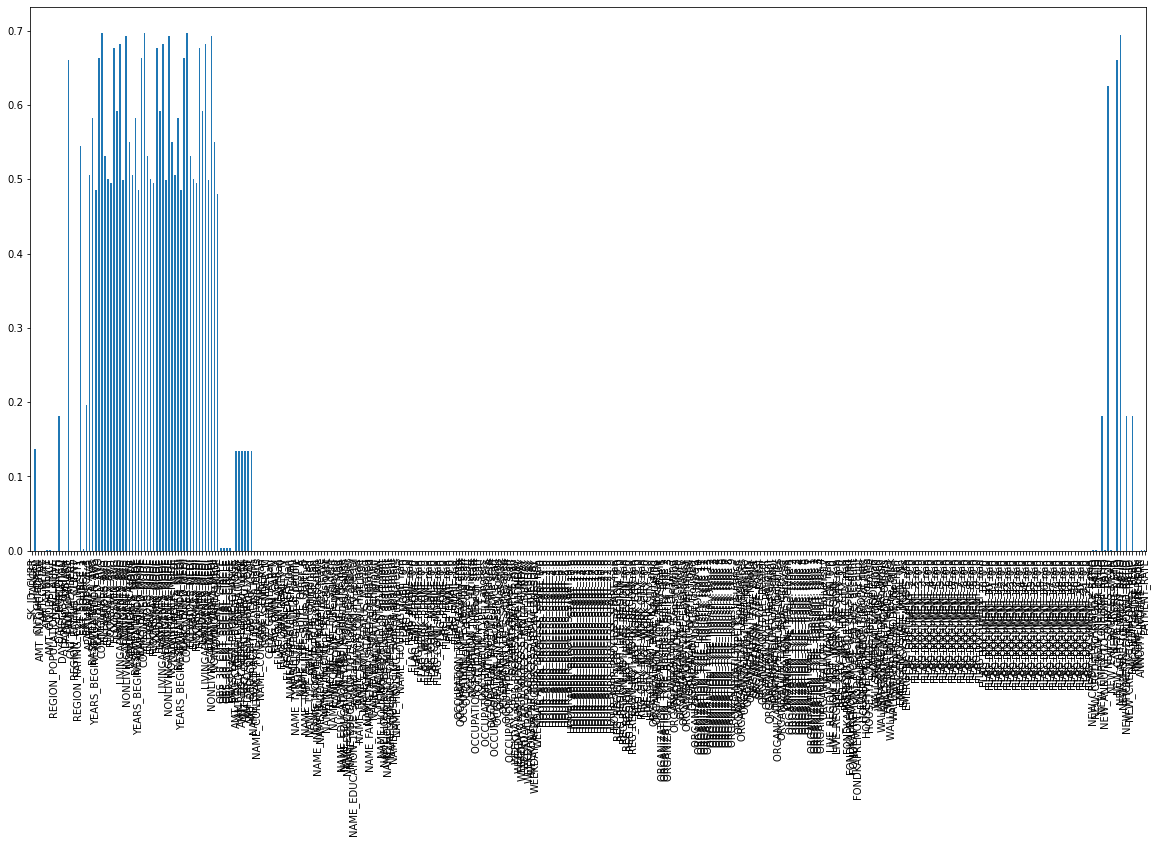

In [54]:
A = df.isna().sum()/df.shape[0]
plt.figure(figsize=(20,10))
A.plot.bar()
plt.show()

In [55]:
print(f"Nombre de features avec des NaN : {len(A[A>0])-1}")

Nombre de features avec des NaN : 76


In [56]:
t0=time.time()
bureau, bureau_num, bureau_cat = bureau_and_balance()
df = df.merge(bureau, how='left', on='SK_ID_CURR')
print(f"Dataframe new shape : {df.shape}")
del bureau
gc.collect()
t1=time.time()
time_process = "{:.2f}".format(t1 - t0)
print(f"Process bureau and bureau_balance - done in {time_process} s")

Bureau shape: (1716428, 17), Bureau Balance shape: (27299925, 3)
Bureau balance après agrégation selon SK_ID_BUREAU


,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_nan_MEAN
SK_ID_BUREAU,,,,,,,,,,,,
5001709,-96,0,97,0.000000,0.0,0.0,0.0,0.0,0.0,0.886598,0.113402,0
5001710,-82,0,83,0.060241,0.0,0.0,0.0,0.0,0.0,0.578313,0.361446,0
5001711,-3,0,4,0.750000,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000,0


Bureau shape après merge : (1716428, 51)


,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_ACTIVE_nan,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_CURRENCY_nan,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_nan,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_nan_MEAN
0,215354,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,-131,NaN,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,-20,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,-16,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Bureau après agrégation selon SK_ID_CURR : shape (305811, 55)
Nombres de variables numériques après agrégation: 20
Nombres de variables catégorielles après agrégation: 35


,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_ANNUITY_MAX,BURO_AMT_ANNUITY_MEAN,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_MIN_MIN,BURO_MONTHS_BALANCE_MAX_MAX,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Bad debt_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,BURO_CREDIT_ACTIVE_nan_MEAN,BURO_CREDIT_CURRENCY_currency 1_MEAN,BURO_CREDIT_CURRENCY_currency 2_MEAN,BURO_CREDIT_CURRENCY_currency 3_MEAN,BURO_CREDIT_CURRENCY_currency 4_MEAN,BURO_CREDIT_CURRENCY_nan_MEAN,BURO_CREDIT_TYPE_Another type of loan_MEAN,BURO_CREDIT_TYPE_Car loan_MEAN,BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,BURO_CREDIT_TYPE_Consumer credit_MEAN,BURO_CREDIT_TYPE_Credit card_MEAN,BURO_CREDIT_TYPE_Interbank credit_MEAN,BURO_CREDIT_TYPE_Loan for business development_MEAN,BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_TYPE_Mobile operator loan_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_CREDIT_TYPE_Real estate loan_MEAN,BURO_CREDIT_TYPE_Unknown type of loan_MEAN,BURO_CREDIT_TYPE_nan_MEAN,BURO_STATUS_0_MEAN_MEAN,BURO_STATUS_1_MEAN_MEAN,BURO_STATUS_2_MEAN_MEAN,BURO_STATUS_3_MEAN_MEAN,BURO_STATUS_4_MEAN_MEAN,BURO_STATUS_5_MEAN_MEAN,BURO_STATUS_C_MEAN_MEAN,BURO_STATUS_X_MEAN_MEAN,BURO_STATUS_nan_MEAN_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-735.00,240043.666667,82.428571,-93.142857,0.0,NaN,207623.571429,1453365.000,85240.928571,596686.5,0.0,0.00000,0.000,10822.5,3545.357143,0,-51.0,0.0,24.571429,172.0,0.428571,0.0,0.571429,0.0,0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.336651,0.007519,0.0,0.0,0.0,0.0,0.441240,0.214590,0.0
100002,-874.00,186150.000000,-349.000000,-499.875000,0.0,1681.029,108131.945625,865055.565,49156.200000,245781.0,0.0,7997.14125,31988.565,0.0,0.000000,0,-47.0,0.0,13.750000,110.0,0.250000,0.0,0.750000,0.0,0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.406960,0.255682,0.0,0.0,0.0,0.0,0.175426,0.161932,0.0
100003,-1400.75,827783.583333,-544.500000,-816.000000,0.0,0.000,254350.125000,1017400.500,0.000000,0.0,0.0,202500.00000,810000.000,NaN,NaN,0,NaN,NaN,NaN,0.0,0.250000,0.0,0.750000,0.0,0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Features NaN avant imputing : 2601029
Num Features NaN avant imputing : 1059608
Num Features NaN après imputing : 0
Dataframe new shape : (356255, 421)
Process bureau and bureau_balance - done in 37.38 s


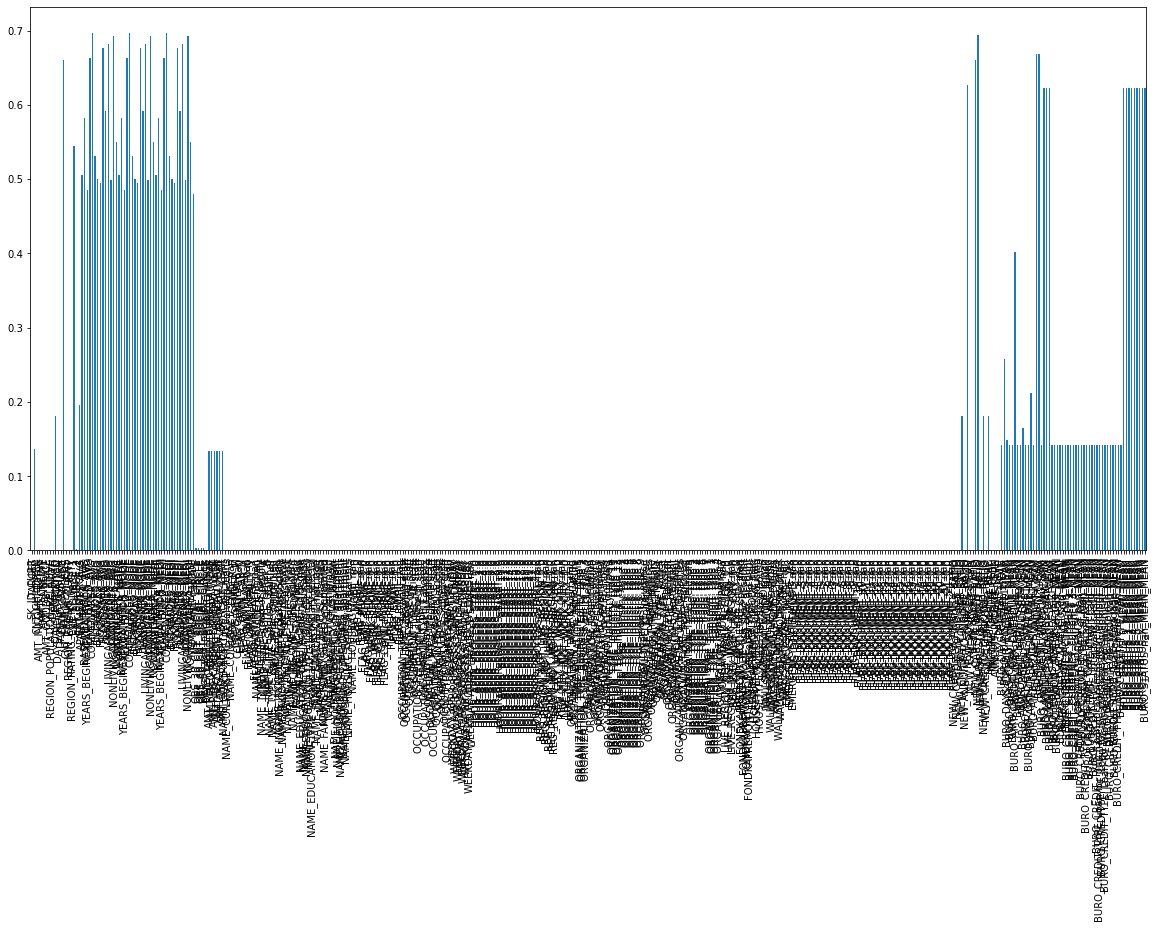

In [57]:
B = df.isna().sum()/df.shape[0]
plt.figure(figsize=(20,10))
B.plot.bar()
plt.show()

In [58]:
print(f"Nombre de features avec des NaN : {len(B[B>0])-1}")
print(f"Nombre de nouvelles features avec des NaN :{len(B[B>0]) - len(A[A>0])}")

Nombre de features avec des NaN : 131
Nombre de nouvelles features avec des NaN :55


In [59]:
t0=time.time()
prev, prev_num, prev_cat = previous_applications()
df = df.merge(prev, how='left', on='SK_ID_CURR')
print(f"Dataframe new shape : {df.shape}")
del prev
gc.collect()
t1=time.time()
time_process = "{:.2f}".format(t1 - t0)
print(f"Process previous application - done in {time_process} s")

Previous applications shape: (1670214, 37)
Previous applications après agrégation selon SK_ID_CURR : shape (338857, 228)
Nombres de variables numériques après agrégation: 48
Nombres de variables catégorielles après agrégation: 187


,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_GOODS_PRICE_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_RATE_INTEREST_PRIMARY_MIN,PREV_RATE_INTEREST_PRIMARY_MAX,PREV_RATE_INTEREST_PRIMARY_MEAN,PREV_RATE_INTEREST_PRIVILEGED_MIN,PREV_RATE_INTEREST_PRIVILEGED_MAX,PREV_RATE_INTEREST_PRIVILEGED_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_SELLERPLACE_AREA_MIN,PREV_SELLERPLACE_AREA_MAX,PREV_SELLERPLACE_AREA_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_DAYS_FIRST_DRAWING_MIN,PREV_DAYS_FIRST_DRAWING_MAX,PREV_DAYS_FIRST_DRAWING_MEAN,PREV_DAYS_FIRST_DUE_MIN,PREV_DAYS_FIRST_DUE_MAX,PREV_DAYS_FIRST_DUE_MEAN,PREV_DAYS_LAST_DUE_1ST_VERSION_MIN,PREV_DAYS_LAST_DUE_1ST_VERSION_MAX,PREV_DAYS_LAST_DUE_1ST_VERSION_MEAN,PREV_DAYS_LAST_DUE_MIN,PREV_DAYS_LAST_DUE_MAX,PREV_DAYS_LAST_DUE_MEAN,PREV_DAYS_TERMINATION_MIN,PREV_DAYS_TERMINATION_MAX,PREV_DAYS_TERMINATION_MEAN,PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN,PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN,PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN,PREV_NAME_CONTRACT_TYPE_nan_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN,PREV_HOUR_APPR_PROCESS_START_0.0_MEAN,PREV_HOUR_APPR_PROCESS_START_1.0_MEAN,PREV_HOUR_APPR_PROCESS_START_2.0_MEAN,PREV_HOUR_APPR_PROCESS_START_3.0_MEAN,PREV_HOUR_APPR_PROCESS_START_4.0_MEAN,PREV_HOUR_APPR_PROCESS_START_5.0_MEAN,PREV_HOUR_APPR_PROCESS_START_6.0_MEAN,PREV_HOUR_APPR_PROCESS_START_7.0_MEAN,PREV_HOUR_APPR_PROCESS_START_8.0_MEAN,PREV_HOUR_APPR_PROCESS_START_9.0_MEAN,PREV_HOUR_APPR_PROCESS_START_10.0_MEAN,PREV_HOUR_APPR_PROCESS_START_11.0_MEAN,PREV_HOUR_APPR_PROCESS_START_12.0_MEAN,PREV_HOUR_APPR_PROCESS_START_13.0_MEAN,PREV_HOUR_APPR_PROCESS_START_14.0_MEAN,PREV_HOUR_APPR_PROCESS_START_15.0_MEAN,PREV_HOUR_APPR_PROCESS_START_16.0_MEAN,PREV_HOUR_APPR_PROCESS_START_17.0_MEAN,PREV_HOUR_APPR_PROCESS_START_18.0_MEAN,PREV_HOUR_APPR_PROCESS_START_19.0_MEAN,PREV_HOUR_APPR_PROCESS_START_20.0_MEAN,PREV_HOUR_APPR_PROCESS_START_21.0_MEAN,PREV_HOUR_APPR_PROCESS_START_22.0_MEAN,PREV_HOUR_APPR_PROCESS_START_23.0_MEAN,PREV_HOUR_APPR_PROCESS_START_nan_MEAN,PREV_NFLAG_LAST_APPL_IN_DAY_0.0_MEAN,PREV_NFLAG_LAST_APPL_IN_DAY_1.0_MEAN,PREV_NFLAG_LAST_APPL_IN_DAY_nan_MEAN,PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN,PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN,PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a used car_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Car repairs_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN,...,PREV_CODE_REJECT_REASON_SCO_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_SYSTEM_MEAN,PREV_CODE_REJECT_REASON_VERIF_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_CODE_REJECT_REASON_nan_MEAN,PREV_NAME_TYPE_SUITE_Children_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,PREV_NAME_TYPE_SUITE_Group of people_MEAN,PREV_NAME_TYPE_SUITE_Other_A_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,"PREV_NAME_TYPE_SUITE_Spouse, partner_MEAN",PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_T

Features NaN avant imputing : 3129436
Num Features NaN avant imputing : 3129436
Num Features NaN après imputing : 0
Dataframe new shape : (356255, 649)
Process previous application - done in 171.75 s


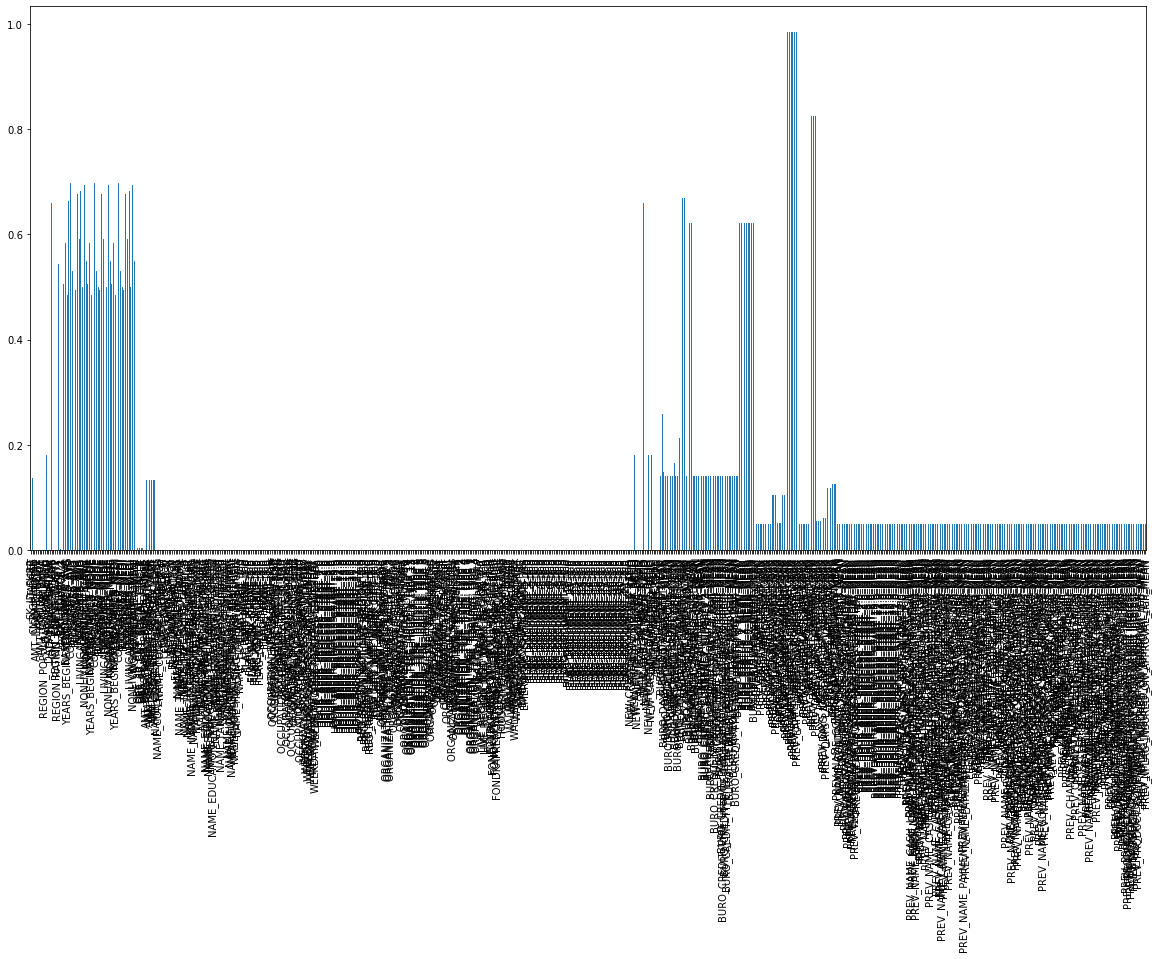

In [60]:
C = df.isna().sum()/df.shape[0]
plt.figure(figsize=(20,10))
C.plot.bar()
plt.show()

In [61]:
print(f"Nombre de features avec des NaN : {len(C[C>0])-1}")
print(f"Nombre de nouvelles features avec des NaN :{len(C[C>0]) - len(B[B>0])}")

Nombre de features avec des NaN : 359
Nombre de nouvelles features avec des NaN :228


In [62]:
t0=time.time()
pos, pos_num, pos_cat = pos_cash()
df = df.merge(pos, how='left', on='SK_ID_CURR')
print(f"Dataframe new shape : {df.shape}")
del pos
gc.collect()
t1=time.time()
time_process = "{:.2f}".format(t1 - t0)
print(f"Process POS_CASH_balance - done in {time_process} s")

POS CASH balance shape: (10001358, 8)
POS CASH balance après agrégation selon SK_ID_CURR : shape (337252, 25)
Nombres de variables numériques après agrégation: 16
Nombres de variables catégorielles après agrégation: 9


,POS_MONTHS_BALANCE_MIN,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_CNT_INSTALMENT_MIN,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_FUTURE_MIN,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_SK_DPD_MIN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MIN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT_
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-96,-53,-72.555556,4.0,4.0,4.000000,0.0,4.0,1.444444,0,7,0.777778,0,7,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,9
100002,-19,-1,-10.000000,24.0,24.0,24.000000,6.0,24.0,15.000000,0,0,0.000000,0,0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,19
100003,-77,-18,-43.785714,6.0,12.0,10.107143,0.0,12.0,5.785714,0,0,0.000000,0,0,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,28


Features NaN avant imputing : 168
Num Features NaN avant imputing : 168
Num Features NaN après imputing : 0
Dataframe new shape : (356255, 674)
Process POS_CASH_balance - done in 25.38 s


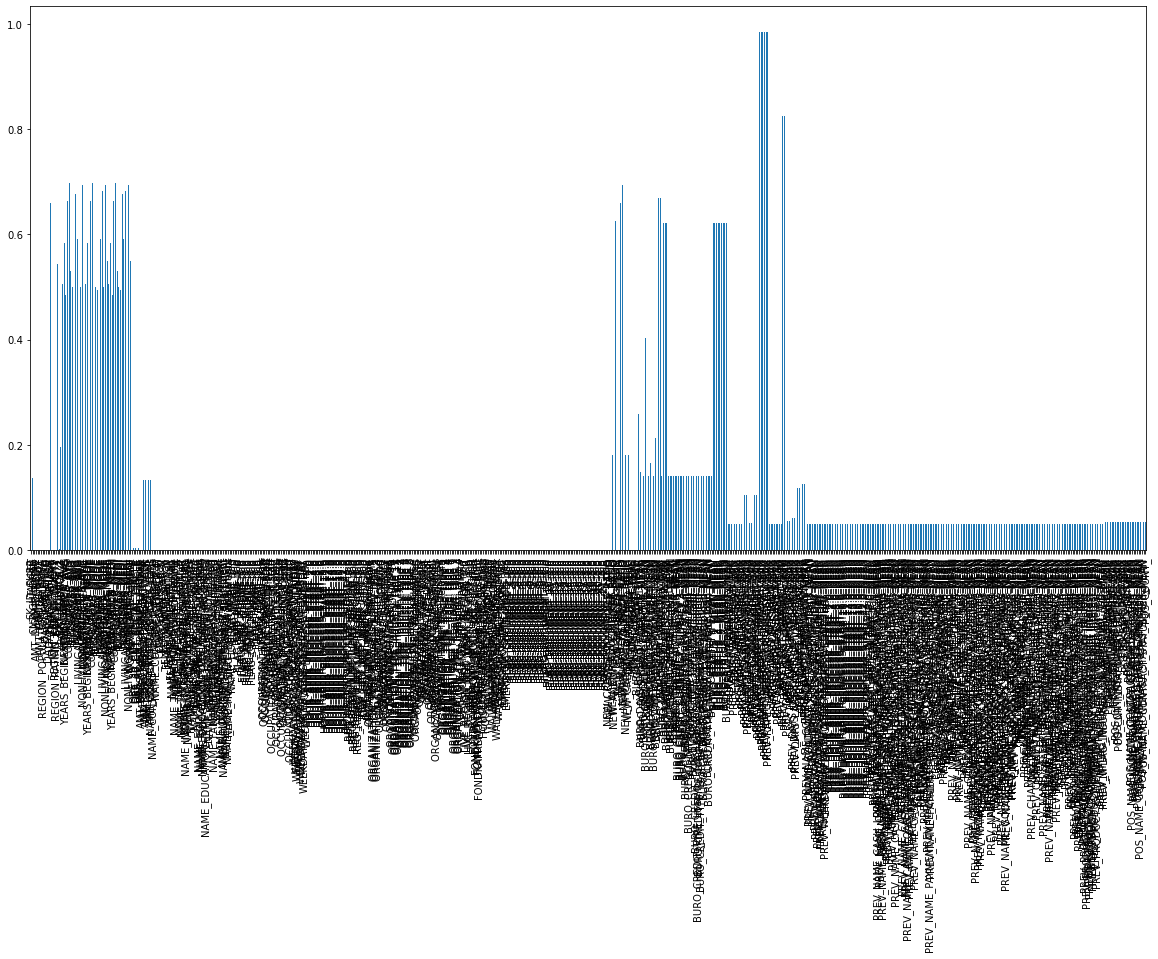

In [63]:
D = df.isna().sum()/df.shape[0]
plt.figure(figsize=(20,10))
D.plot.bar()
plt.show()

In [64]:
print(f"Nombre de features avec des NaN : {len(D[D>0])-1}")
print(f"Nombre de nouvelles features avec des NaN :{len(D[D>0]) - len(C[C>0])}")

Nombre de features avec des NaN : 384
Nombre de nouvelles features avec des NaN :25


In [65]:
t0=time.time()
ins, ins_num, ins_cat = inst_payments()
df = df.merge(ins, how='left', on='SK_ID_CURR')
print(f"Dataframe new shape : {df.shape}")
del ins
gc.collect()
t1=time.time()
time_process = "{:.2f}".format(t1 - t0)
print(f"Process Installments payments - done in {time_process} s")

Installments_payments shape: (13605401, 8)
Installments payments après agrégation selon SK_ID_CURR : shape (339587, 369)
Nombres de variables numériques après agrégation: 25
Nombres de variables catégorielles après agrégation: 344


,INSTAL_DAYS_INSTALMENT_MIN,INSTAL_DAYS_INSTALMENT_MAX,INSTAL_DAYS_INSTALMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_AMT_INSTALMENT_MIN,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_NUM_INSTALMENT_VERSION_0.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_1.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_2.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_3.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_4.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_5.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_6.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_7.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_8.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_9.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_10.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_11.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_12.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_13.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_14.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_15.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_16.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_17.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_18.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_19.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_20.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_21.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_22.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_23.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_24.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_25.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_26.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_27.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_28.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_29.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_30.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_31.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_32.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_33.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_34.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_35.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_36.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_37.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_38.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_39.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_40.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_41.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_42.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_43.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_44.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_45.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_46.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_47.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_48.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_49.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_50.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_51.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_52.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_53.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_54.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_55.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_56.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_57.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_58.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_59.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_61.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_68.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_72.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_73.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_178.0_MEAN,INSTAL_NUM_INSTALMENT_VERSION_nan_MEAN,INSTAL_NUM_INSTALMENT_NUMBER_1.0_MEAN,INSTAL_NUM_INSTALMENT_NUMBER_2.0_MEAN,INSTAL_NUM_INSTALMENT_NUMBER_3.0_MEAN,INSTAL_NUM_INSTALMENT_NUMBER_4.0_MEAN,INSTAL_NUM_INSTALMENT_NUMBER_5.0_MEAN,INSTAL_NUM_INSTALMENT_NUMBER_6.0_MEAN,INSTAL_NUM_INSTALMENT_NUMBER_7.0_MEAN,INSTAL_NUM_INSTALMENT_NUMBER_8.0_MEAN,INSTAL_NUM_INSTALMENT_NUMBER_9.0_MEAN,INSTAL_NUM_INSTALMENT_NUMBER_10.0_MEAN,...,INSTAL_NUM_INSTALMENT_NUMBER_180.0_MEAN,INSTAL_NUM_INSTALMENT_NUMBER_181.0_MEAN,INSTAL_NUM_INSTALMENT_NUMBER_182.0_MEAN,INSTAL_NUM_INSTALMENT_NUMBER_183.0_MEAN,INSTAL_NUM_INSTALMENT_NUMBER_184.0_MEAN,INSTAL_NUM_INSTALMENT_NUMBER_185.0_MEAN,INSTAL_NUM_INSTALMENT_NUMBER_186.0_MEAN,INSTAL_NUM_INSTALMENT_NUMBER_187.0_MEAN,INSTAL_NUM_INSTALMENT_NUMBER_188.0_MEAN,INSTAL_NUM_INSTALMENT_NUMBER_189.0_MEAN,INSTAL_NUM_INSTALMENT_NU

Cat Features NaN avant imputing : 0
Cat Features NaN après imputing : 0
Features NaN après imputing : 2026
Dataframe new shape : (356255, 1043)
Process Installments payments - done in 310.30 s


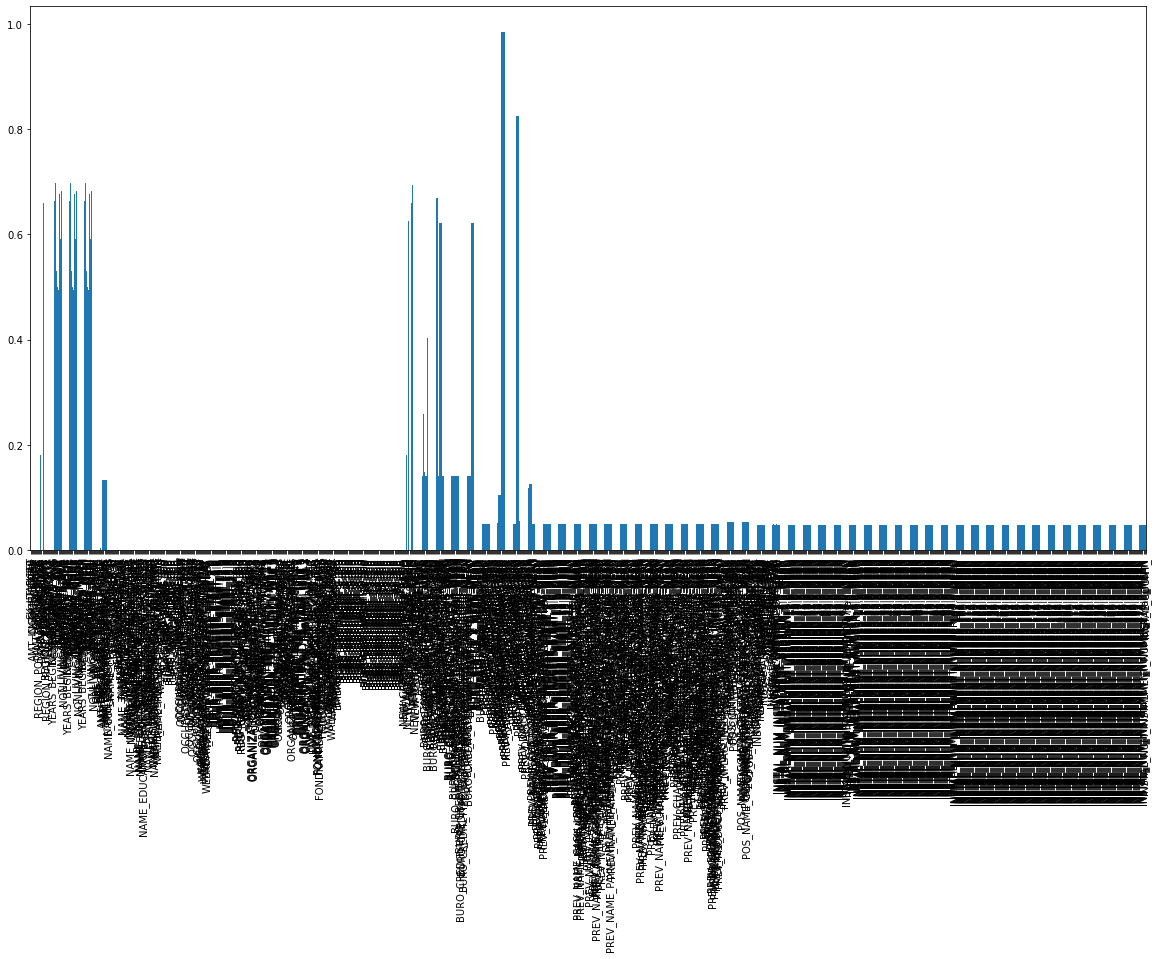

In [66]:
E = df.isna().sum()/df.shape[0]
plt.figure(figsize=(20,10))
E.plot.bar()
plt.show()

In [67]:
print(f"Nombre de features avec des NaN : {len(E[E>0])-1}")
print(f"Nombre de nouvelles features avec des NaN :{len(E[E>0]) - len(D[D>0])}")

Nombre de features avec des NaN : 753
Nombre de nouvelles features avec des NaN :369


In [68]:
t0=time.time()
cc, cc_num, cc_cat = cc_balance()
df = df.merge(cc, how='left', on='SK_ID_CURR')
print(f"Dataframe new shape : {df.shape}")
del cc
gc.collect()
t1=time.time()
time_process = "{:.2f}".format(t1 - t0)
print(f"Process Credit card balance - done in {time_process} s")

Credit Card Balance shape: (3840312, 23)
Credit Card Balance après agrégation selon SK_ID_CURR : shape (103558, 109)
Nombres de variables numériques après agrégation: 101
Nombres de variables catégorielles après agrégation: 8


,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,CC_AMT_CREDIT_LIMIT_ACTUAL_MIN,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,CC_AMT_CREDIT_LIMIT_ACTUAL_VAR,CC_AMT_DRAWINGS_ATM_CURRENT_MIN,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,CC_AMT_DRAWINGS_ATM_CURRENT_VAR,CC_AMT_DRAWINGS_CURRENT_MIN,CC_AMT_DRAWINGS_CURRENT_MAX,CC_AMT_DRAWINGS_CURRENT_MEAN,CC_AMT_DRAWINGS_CURRENT_SUM,CC_AMT_DRAWINGS_CURRENT_VAR,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CC_AMT_DRAWINGS_OTHER_CURRENT_SUM,CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,CC_AMT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_MEAN,CC_AMT_DRAWINGS_POS_CURRENT_SUM,CC_AMT_DRAWINGS_POS_CURRENT_VAR,CC_AMT_INST_MIN_REGULARITY_MIN,CC_AMT_INST_MIN_REGULARITY_MAX,CC_AMT_INST_MIN_REGULARITY_MEAN,CC_AMT_INST_MIN_REGULARITY_SUM,CC_AMT_INST_MIN_REGULARITY_VAR,CC_AMT_PAYMENT_CURRENT_MIN,CC_AMT_PAYMENT_CURRENT_MAX,CC_AMT_PAYMENT_CURRENT_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_AMT_PAYMENT_CURRENT_VAR,CC_AMT_PAYMENT_TOTAL_CURRENT_MIN,CC_AMT_PAYMENT_TOTAL_CURRENT_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_SUM,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,CC_AMT_RECEIVABLE_PRINCIPAL_MIN,CC_AMT_RECEIVABLE_PRINCIPAL_MAX,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_AMT_RECEIVABLE_PRINCIPAL_SUM,CC_AMT_RECEIVABLE_PRINCIPAL_VAR,CC_AMT_RECIVABLE_MIN,CC_AMT_RECIVABLE_MAX,CC_AMT_RECIVABLE_MEAN,CC_AMT_RECIVABLE_SUM,CC_AMT_RECIVABLE_VAR,CC_AMT_TOTAL_RECEIVABLE_MIN,CC_AMT_TOTAL_RECEIVABLE_MAX,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_AMT_TOTAL_RECEIVABLE_SUM,CC_AMT_TOTAL_RECEIVABLE_VAR,CC_CNT_DRAWINGS_ATM_CURRENT_MIN,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_COUNT_
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100006,-6,-1,-3.5,-21,3.5,0.0,0.00,0.000000,0.000,0.000000e+00,270000,270000,270000.000000,1620000,0.000000e+00,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.000000,0.0,0.000000e+00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.000000,0.000,0.000000e+00,NaN,NaN,NaN,0.00,NaN,0.0,0.0,0.000000,0.000,0.000000e+00,0.0,0.0,0.000000,0.000,0.000000e+00,0.000,0.00,0.000000,0.000,0.000000e+00,0.000,0.00,0.000000,0.000,0.000000e+00,NaN,NaN,NaN,0.0,NaN,0,0,0.000000,0,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.000000,0.0,0.000000,0,0,0.000000,0,0.000000,0,0,0.000000,0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,6
100011,-75,-2,-38.5,-2849,462.5,0.0,189000.00,54482.111149,4031676.225,4.641321e+09,90000,180000,164189.189189,12150000,1.189060e+09,0.0,18

Cat Features NaN avant imputing : 0
Cat Features NaN après imputing : 0
Features NaN après imputing : 891014
Dataframe new shape : (356255, 1152)
Process Credit card balance - done in 23.05 s


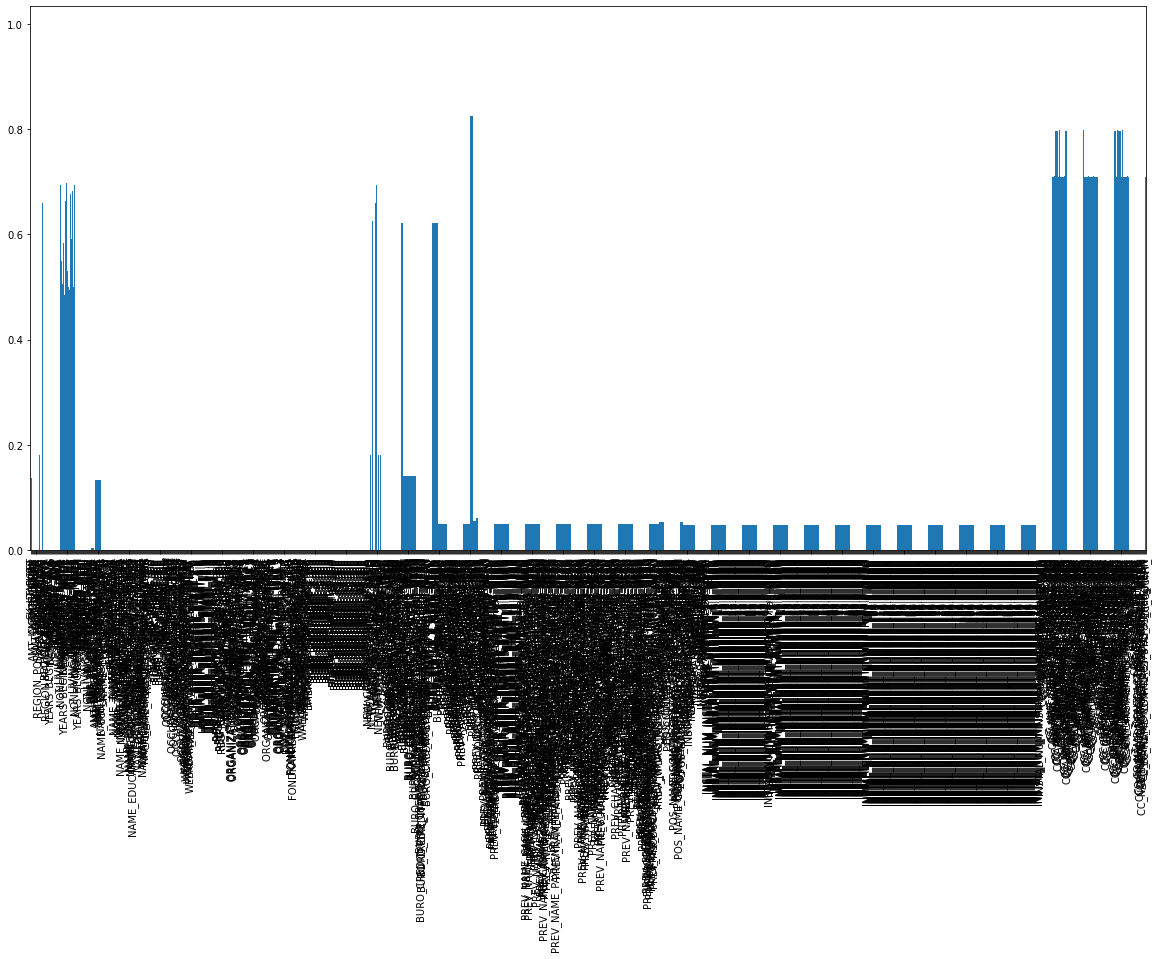

In [69]:
F = df.isna().sum()/df.shape[0]
plt.figure(figsize=(20,10))
F.plot.bar()
plt.show()

In [70]:
print(f"Nombre de features avec des NaN : {len(F[F>0])-1}")
print(f"Nombre de nouvelles features avec des NaN :{len(F[F>0]) - len(E[E>0])}")

Nombre de features avec des NaN : 862
Nombre de nouvelles features avec des NaN :109


In [71]:
df.to_csv('pretreated_data_1.csv', index=False)
joblib.dump(app_cat, 'app_cat.sav')
joblib.dump(bureau_cat, 'bureau_cat.sav')
joblib.dump(prev_cat, 'prev_cat.sav')
joblib.dump(pos_cat, 'pos_cat.sav')
joblib.dump(ins_cat, 'ins_cat.sav')
joblib.dump(cc_cat, 'cc_cat.sav')
joblib.dump(app_num, 'app_num.sav')
joblib.dump(bureau_num, 'bureau_num.sav')
joblib.dump(prev_num, 'prev_num.sav')
joblib.dump(pos_num, 'pos_num.sav')
joblib.dump(ins_num, 'ins_num.sav')
joblib.dump(cc_num, 'cc_num.sav')

cat_col_tot = app_cat + bureau_cat + prev_cat + pos_cat + ins_cat + cc_cat
num_col_tot = app_num + bureau_num + prev_num + pos_num + ins_num + cc_num
joblib.dump(cat_col_tot, 'cat_col_tot.sav')
joblib.dump(num_col_tot, 'num_col_tot.sav')

['num_col_tot.sav']

## Selection des features 

In [73]:
df=pd.read_csv('pretreated_data_1.csv')
num_cols = joblib.load('app_num.sav')
cat_cols = joblib.load('app_cat.sav')

In [74]:
# Selection des features app_num et app_cat
df_2 = df[num_cols+cat_cols+['TARGET', 'SK_ID_CURR']]
print(f"Nombres de features avant : {df.shape[1]}")
print(f"Nombres de features après : {df_2.shape[1]}")

Nombres de features avant : 1152
Nombres de features après : 366


In [75]:
df_2.to_csv('pretreated_data_2.csv', index=False)

## Modélisation

### Division Train test

In [40]:
df_2 = pd.read_csv('pretreated_data_2.csv')

In [76]:
train_df = df_2[df_2['TARGET'].notnull()]
test_df = df_2[df_2['TARGET'].isnull()]
print(f"App Train shape: {train_df.shape}")
print(f"App Test shape: {test_df.shape}")

App Train shape: (307511, 366)
App Test shape: (48744, 366)


In [77]:
test_df.to_csv('test_df.csv', index=False)
train_df.to_csv('train_df.csv', index=False)

In [94]:
# Train et test avec imputing
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

train_x, train_y = train_df[feats], train_df['TARGET']
test_x = test_df[feats]

# Iterative Imputing
imputed_train_x = iimputer(train_x.loc[:, num_cols])
train_x.loc[:, num_cols] = imputed_train_x

imputed_test_x = iimputer(test_x.loc[:, num_cols])
test_x.loc[:, num_cols] = imputed_test_x

# Dataset finaux

train_df_bis = pd.concat([train_x, train_df['SK_ID_CURR'], train_y], axis=1)
test_df_bis = pd.concat([test_x, test_df[['TARGET', 'SK_ID_CURR']]], axis=1)

test_df_bis.to_csv('test_df_bis.csv', index=False)
train_df_bis.to_csv('train_df_bis.csv', index=False)

C:\Users\ilyas\anaconda3\lib\site-packages\pandas\core\indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
C:\Users\ilyas\anaconda3\lib\site-packages\pandas\core\indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [3]:
# Sampling de 10% des datasets
train_df_bis = pd.read_csv('train_df_bis.csv')
test_df_bis = pd.read_csv('test_df_bis.csv')

from sklearn.model_selection import train_test_split

train_df_bis_x = train_df_bis.drop(columns='TARGET')
train_df_bis_y = train_df_bis['TARGET']

train_df_ter_x, train_df_ter_xb, train_df_ter_y, train_df_ter_yb = train_test_split(train_df_bis_x, 
                                                                                    train_df_bis_y,
                                                                                    train_size=0.03)
train_df_ter = pd.concat([train_df_ter_x, train_df_ter_y], axis=1)

test_df_ter = test_df_bis.sample(frac=0.03)

test_df_ter.to_csv('test_df_ter.csv', index=False)
train_df_ter.to_csv('train_df_ter.csv', index=False)

### Cross Validation

### Définition du score

In [78]:
# def custom_metric(y, y_pred):
#     beta=10
#     tp, fn, fp, tn = confusion_matrix(y, y_pred).ravel()
#     score = (tp + tn) / (tp + tn + beta * fp + fn)
    
#     return score

In [79]:
def custom_metric(y, y_pred):
    beta=2
    score = fbeta_score(y, y_pred, beta=beta)
    
    return score

In [80]:
from sklearn.metrics import make_scorer

custom_score = make_scorer(custom_metric, greater_is_better=True)

### Définition du nombre de fold pour la CV

In [81]:
nb_cv=3

### Baseline

In [49]:
# DummyClassifier with F1

params = {'strategy': 'stratified'}
model = mp1(
    preprocessing,
    DummyClassifier(**params))

train_score_0, val_score_0=cv(train_df=train_df, model=model,
                              num_folds=nb_cv, stratified=True, over_sampling=True, score_name='f1')
val_score_0.mean()

[[47047 47182]
 [ 4223  4052]]
Fold n°1: Train score 0.49960695999490107 et Valscore 0.13618108185316508
[[47171 47058]
 [ 4221  4054]]
Fold n°2: Train score 0.49828098347937444 et Valscore 0.13652819640662098
[[46921 47307]
 [ 4131  4144]]
Fold n°3: Train score 0.5008086539226344 et Valscore 0.13876703613166794


0.13715877146381802

In [50]:
# DummyClassifier with Custom

params = {'strategy': 'stratified'}
model = mp1(
    preprocessing,
    DummyClassifier(**params))

train_score_0, val_score_0=cv(train_df=train_df, model=model,
                              num_folds=nb_cv, stratified=True, over_sampling=True, score_name='custom')
val_score_0.mean()

[[47125 47104]
 [ 4128  4147]]
Fold n°1: Train score 0.5001613115477843 et Valscore 0.24581806973242756
[[47006 47223]
 [ 4105  4170]]
Fold n°2: Train score 0.5006292751980678 et Valscore 0.24676600428437856
[[47028 47200]
 [ 4139  4136]]
Fold n°3: Train score 0.4990599988117366 et Valscore 0.2449192287649818


0.24583443426059595

### Gaussian Naive Bayes

#### Score F1

In [51]:
score_name='f1'

In [52]:
# Gaussian Naive Bayes F1

params = {}
model = mp1(
    preprocessing,
    GaussianNB(**params))

train_score_1, val_score_1=cv(train_df=train_df, model=model,
                              num_folds=nb_cv, stratified=True, over_sampling=True, score_name=score_name)
val_score_1.mean()

[[55978 38251]
 [ 4655  3620]]
Fold n°1: Train score 0.801394500224956 et Valscore 0.1443784150281179
[[56996 37233]
 [ 4839  3436]]
Fold n°2: Train score 0.8047473479265608 et Valscore 0.14040536122915986
[[55268 38960]
 [ 4620  3655]]
Fold n°3: Train score 0.7989909796281489 et Valscore 0.14364315189624682


0.14280897605117487

In [53]:
# Grille de recherche d'hyperparamètres F1
space = {
    "var_smoothing": hp.uniform("var_smoothing", 1e-9, 1e-3)
}

trials_gnb = Trials()

best = fmin(fn=hyperparameter_tuning_GNB,
            space = space, 
            algo=tpe.suggest,
            max_evals=10,
            trials=trials_gnb
           )

print("Best: {}".format(best))

100%|███████████████████████████████████████████| 10/10 [1:11:41<00:00, 430.18s/trial, best loss: -0.13349587684159728]
Best: {'var_smoothing': 0.00020427329252617043}


In [54]:
trials_gnb.results

[{'loss': -0.13275307874435388, 'status': 'ok'},
 {'loss': -0.13277715879038623, 'status': 'ok'},
 {'loss': -0.13279350959209021, 'status': 'ok'},
 {'loss': -0.1311346854544975, 'status': 'ok'},
 {'loss': -0.13038436807464077, 'status': 'ok'},
 {'loss': -0.13259512057860814, 'status': 'ok'},
 {'loss': -0.1333293922638672, 'status': 'ok'},
 {'loss': -0.13349587684159728, 'status': 'ok'},
 {'loss': -0.13013701400186298, 'status': 'ok'},
 {'loss': -0.13032362075998724, 'status': 'ok'}]

#### Custom Score

In [55]:
score_name='custom'

In [56]:
# Gaussian Naive Bayes Custom

params = {}
model = mp1(
    preprocessing,
    GaussianNB(**params))

train_score_1, val_score_1=cv(train_df=train_df, model=model,
                              num_folds=nb_cv, stratified=True, over_sampling=True, score_name=score_name)
val_score_1.mean()

[[55978 38251]
 [ 4655  3620]]
Fold n°1: Train score 0.879406160685932 et Valscore 0.24142668498486083
[[56996 37233]
 [ 4839  3436]]
Fold n°2: Train score 0.8801057086028535 et Valscore 0.2328891539806694
[[55268 38960]
 [ 4620  3655]]
Fold n°3: Train score 0.8786380402013536 et Valscore 0.24136564749389158


0.23856049548647393

In [57]:
# Grille de recherche d'hyperparamètres Custom
space = {
    "var_smoothing": hp.uniform("var_smoothing", 1e-9, 1e-3)
}

trials_gnb = Trials()

best = fmin(fn=hyperparameter_tuning_GNB,
            space = space, 
            algo=tpe.suggest,
            max_evals=10,
            trials=trials_gnb
           )

print("Best: {}".format(best))

100%|███████████████████████████████████████████| 10/10 [1:11:07<00:00, 426.77s/trial, best loss: -0.20440410678492316]
Best: {'var_smoothing': 5.6754509815638265e-05}


In [58]:
trials_gnb.results

[{'loss': -0.20419551011096973, 'status': 'ok'},
 {'loss': -0.18063005782559172, 'status': 'ok'},
 {'loss': -0.17766977811033222, 'status': 'ok'},
 {'loss': -0.17787150275999877, 'status': 'ok'},
 {'loss': -0.1747989334615098, 'status': 'ok'},
 {'loss': -0.1847982397842641, 'status': 'ok'},
 {'loss': -0.18512576616785306, 'status': 'ok'},
 {'loss': -0.20440410678492316, 'status': 'ok'},
 {'loss': -0.17540412577709696, 'status': 'ok'},
 {'loss': -0.17492514352951563, 'status': 'ok'}]

### RandomForest

#### Score F1

In [94]:
score_name='f1'

In [96]:
# RandomForest F1

params = {'n_estimators': 10}
model = RandomForestClassifier(**params, random_state=5)

train_score_2, val_score_2=cv(train_df=train_df, model=model,
                              num_folds=nb_cv, stratified=True, over_sampling=True, score_name=score_name)
val_score_2.mean()

0.0908908733429407

In [62]:
# Grille de recherche d'hyperparamètres F1

space = {"n_estimators": 200,
    "max_features": hp.choice("max_features", ['auto', 'sqrt', 'log2']),
    "max_depth": hp.choice("max_depth", [4, 5, 10]),
    #"min_samples_split": hp.uniform("min_samples_split", 0.0, 1.0),
    #"min_samples_leaf": hp.uniform("min_samples_leaf", 0.0, 0.5), 
    #"max_samples": hp.uniform("max_samples", 0.1, 1.0),
    #"bootstrap" : hp.choice("bootstrap", [True, False])
}

trials_rf = Trials()

best = fmin(fn=hyperparameter_tuning_RF,
            space = space, 
            algo=tpe.suggest,
            max_evals=10,
            trials=trials_rf
           )

print("Best: {}".format(best))

100%|██████████████████████████████████████████| 10/10 [3:13:32<00:00, 1161.25s/trial, best loss: -0.23371610275605992]
Best: {'max_depth': 0, 'max_features': 0}


In [63]:
trials_rf.results

[{'loss': -0.22350236254731928, 'status': 'ok'},
 {'loss': -0.23208696720295677, 'status': 'ok'},
 {'loss': -0.23371610275605992, 'status': 'ok'},
 {'loss': -0.16085350125754516, 'status': 'ok'},
 {'loss': -0.16085350125754516, 'status': 'ok'},
 {'loss': -0.16085350125754516, 'status': 'ok'},
 {'loss': -0.23371610275605992, 'status': 'ok'},
 {'loss': -0.17681603323130135, 'status': 'ok'},
 {'loss': -0.23371610275605992, 'status': 'ok'},
 {'loss': -0.23371610275605992, 'status': 'ok'}]

In [82]:
# Résultats avec best parameters
params={"n_estimators": 200,
        'max_features': 'auto',
        'max_depth': 4,
        #'max_samples': 0.5026586230531795,
        #'min_samples_leaf': 0.10288371817140202,
        #'min_samples_split': 0.05130616834141155,
        #'bootstrap': False
       }
best_model_rf = mp1(preprocessing, RandomForestClassifier(**params, random_state=5))

cv(train_df=train_df, model=best_model_rf, num_folds=nb_cv,
      stratified=True, over_sampling=True, score_name=score_name)
#joblib.dump(best_model_rf, 'rf_bestmodel_f1.sav')

(array([0.86683984, 0.86881486, 0.87005048]),
 array([0.30339427, 0.29533198, 0.29968207]))

In [85]:
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

params = {"n_estimators": 200,
        'max_features': 'auto',
        'max_depth': 4,}

train_x, train_y = train_df[feats], train_df['TARGET']

model = RandomForestClassifier(**params, random_state=5)

# Iterative Imputing
imputed_train_x = iimputer(train_x.loc[:, num_cols])
train_x.loc[:, num_cols] = imputed_train_x

# Resampling
smote = SMOTE(random_state=5)
train_x, train_y = smote.fit_resample(train_x, train_y)

# Training
pip = mp1(
    #preprocessing, 
          model)

pip.fit(train_x, train_y)
joblib.dump(pip, 'rf_bestmodel_f1.sav')

C:\Users\ilyas\anaconda3\lib\site-packages\pandas\core\indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


['rf_bestmodel_f1.sav']

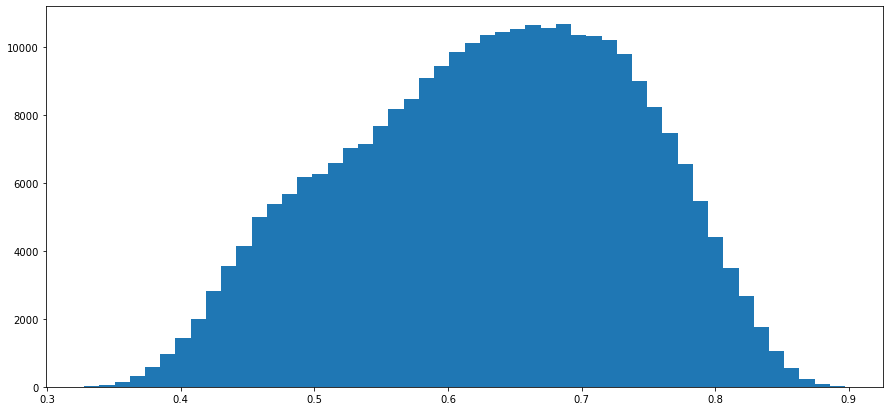

In [159]:
feats = [f for f in train_df_bis.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
index_0 = train_df_bis[train_df_bis['TARGET']==0].index
A = pip.predict_proba(train_df_bis[feats].loc[index_0,:])[:,0]
plt.figure(figsize=(15,7))
plt.hist(x=A, bins=50)
plt.show()

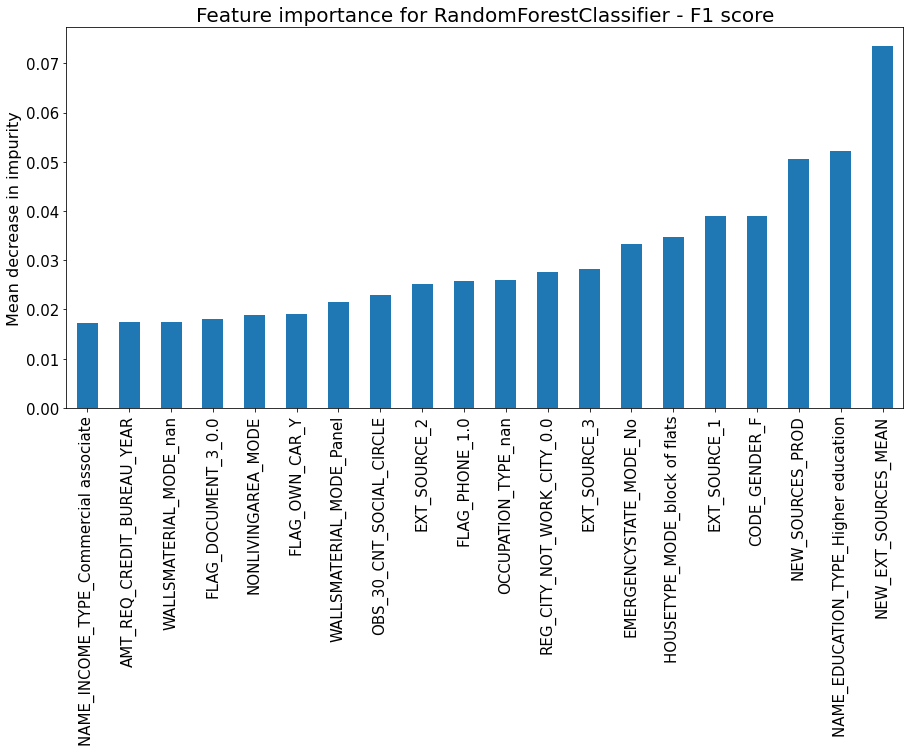

In [86]:
# Features Importances

feature_names = train_df.drop(columns=['SK_ID_CURR', 'TARGET']).columns.to_list()
importances = pip[-1].feature_importances_
std = np.std([tree.feature_importances_ for tree in pip[-1].estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(15,7))
plot = forest_importances.sort_values()[-20:].plot.bar()#yerr=std)
plot.axes.set_title("Feature importance for RandomForestClassifier - F1 score", fontsize = 20)
plot.set_ylabel("Mean decrease in impurity",fontsize=16)
plot.tick_params(labelsize=15)
plt.show()


#### Score Custom

In [146]:
score_name='custom'

In [147]:
# RandomForest Custom

params = {'n_estimators': 10}
model = RandomForestClassifier(**params, random_state=5)

train_score_2, val_score_2=cv(train_df=train_df, model=model,
                                 num_folds=nb_cv, stratified=True, over_sampling=True, score_name=score_name)
val_score_2.mean()

0.0696059250452724

In [148]:
# Grille de recherche d'hyperparamètres Custom
space = {'n_estimators': 200,
    "max_features": hp.choice("max_features", ['auto', 'sqrt', 'log2']),
    "max_depth": hp.choice("max_depth", [4, 5, 10]),
    #"min_samples_split": hp.uniform("min_samples_split", 0.1, 1.0),
    #"min_samples_leaf": hp.uniform("min_samples_leaf", 0.1, 0.5), 
    #"max_samples": hp.uniform("max_samples", 0.1, 1.0),
    #"bootstrap" : hp.choice("bootstrap", [True, False])
}

trials_rf = Trials()

best = fmin(fn=hyperparameter_tuning_RF,
            space = space, 
            algo=tpe.suggest,
            max_evals=10,
            trials=trials_rf
           )

print("Best: {}".format(best))

100%|███████████████████████████████████████████| 10/10 [2:45:16<00:00, 991.64s/trial, best loss: -0.29913099441785956]
Best: {'max_depth': 0, 'max_features': 1}


In [149]:
trials_rf.results

[{'loss': -0.2655305243215936, 'status': 'ok'},
 {'loss': -0.29913099441785956, 'status': 'ok'},
 {'loss': -0.2655305243215936, 'status': 'ok'},
 {'loss': -0.29913099441785956, 'status': 'ok'},
 {'loss': -0.13386022798525188, 'status': 'ok'},
 {'loss': -0.2804821586938691, 'status': 'ok'},
 {'loss': -0.13386022798525188, 'status': 'ok'},
 {'loss': -0.1509691026930171, 'status': 'ok'},
 {'loss': -0.2549970883168966, 'status': 'ok'},
 {'loss': -0.1509691026930171, 'status': 'ok'}]

In [83]:
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

params = {"n_estimators": 200,
        'max_features': 'sqrt',
        'max_depth': 4,}

train_x, train_y = train_df[feats], train_df['TARGET']

model = RandomForestClassifier(**params, random_state=5)

# Iterative Imputing
imputed_train_x = iimputer(train_x.loc[:, num_cols])
train_x.loc[:, num_cols] = imputed_train_x

# Resampling
smote = SMOTE(random_state=5)
train_x, train_y = smote.fit_resample(train_x, train_y)

# Training
#pip = mp1(
    #preprocessing, 
#          model)

model.fit(train_x, train_y)
joblib.dump(model, 'rf_bestmodel_custom.sav')

C:\Users\ilyas\anaconda3\lib\site-packages\pandas\core\indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


['rf_bestmodel_custom.sav']

In [21]:
best_model_rf = joblib.load('rf_bestmodel_custom.sav')

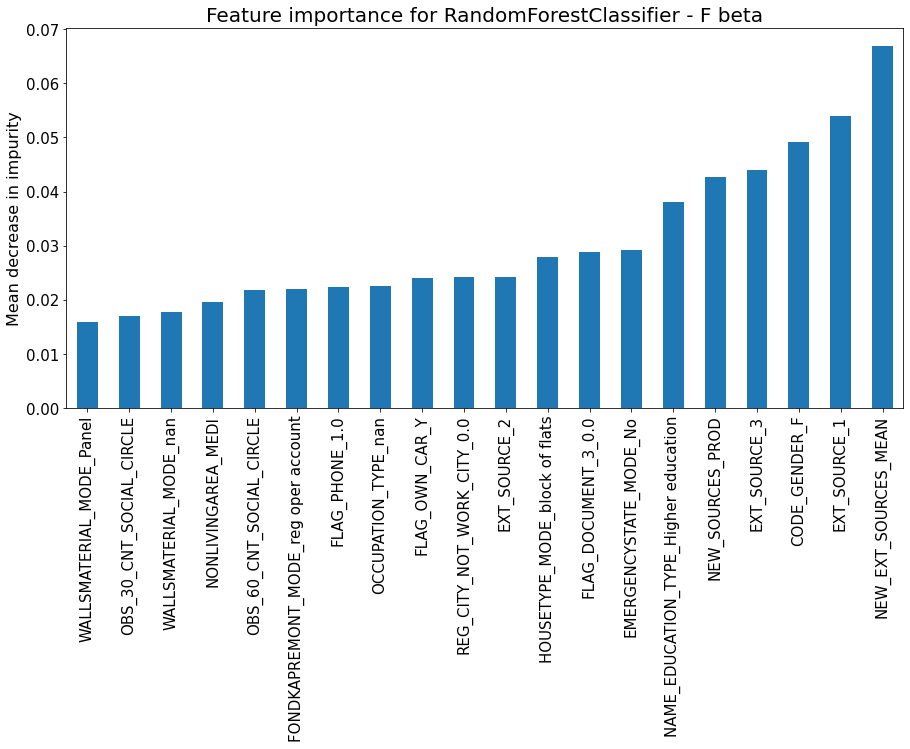

In [85]:
# Features Importances

feature_names = train_df.drop(columns=['SK_ID_CURR', 'TARGET']).columns.to_list()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(15,7))
plot = np.abs(forest_importances).sort_values()[-20:].plot.bar()#yerr=std)
plot.axes.set_title("Feature importance for RandomForestClassifier - F beta", fontsize = 20)
plot.set_ylabel("Mean decrease in impurity",fontsize=16)
plot.tick_params(labelsize=15)
plt.show()

## XGBoost

### Score F1

In [52]:
score_name = 'f1'

In [93]:
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

params = {'n_estimators': 5000,
          'learning_rate': 0.001,
          'max_depth': 10}

train_x, train_y = train_df[feats], train_df['TARGET']

model = XGBClassifier(objective='binary:logistic',
                      use_label_encoder=False,
                      scale_pos_weight=9,
                      nthread=10,
                      seed=27,
                      subsample=0.8,
                      #tree_method='gpu_hist',
                      **params)

# Iterative Imputing
imputed_train_x = iimputer(train_x[num_cols])
train_x[num_cols] = imputed_train_x

# Resampling
#smote = SMOTE(random_state=5)
#train_x, train_y = smote.fit_resample(train_x, train_y)

# Training
model.fit(train_x, train_y)
joblib.dump(model, 'xgb_bestmodel_f1_joblib.json')
model.save_model('xgb_bestmodel_f1_sm.json')

C:\Users\ilyas\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[14:26:47] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

### Score Custom

In [ ]:
score_name = 'custom'

In [89]:
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 5}

train_x, train_y = train_df[feats], train_df['TARGET']

model = XGBClassifier(objective='binary:logistic',
                      use_label_encoder=False,
                      scale_pos_weight=9,
                      nthread=10,
                      seed=27,
                      subsample=0.8,
                      #tree_method='gpu_hist',
                      **params)

# Iterative Imputing
imputed_train_x = iimputer(train_x[num_cols])
train_x[num_cols] = imputed_train_x

# Resampling
#smote = SMOTE(random_state=5)
#train_x, train_y = smote.fit_resample(train_x, train_y)

# Training
#pip = mp1(
    #preprocessing,
    #model)
#pip.fit(train_x, train_y)
model.fit(train_x, train_y, 
          #eval_metric= 'auc', verbose= 100, 
          #early_stopping_rounds= 200
         )
#bst = model.get_booster()
model.save_model('xgb_bestmodel_custom_sm.json')
joblib.dump(model, 'xgb_bestmodel_custom_joblib.json')

C:\Users\ilyas\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[13:59:16] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['xgb_bestmodel_custom_joblib.json']

In [91]:
model = joblib.load('xgb_bestmodel_custom_joblib.json')

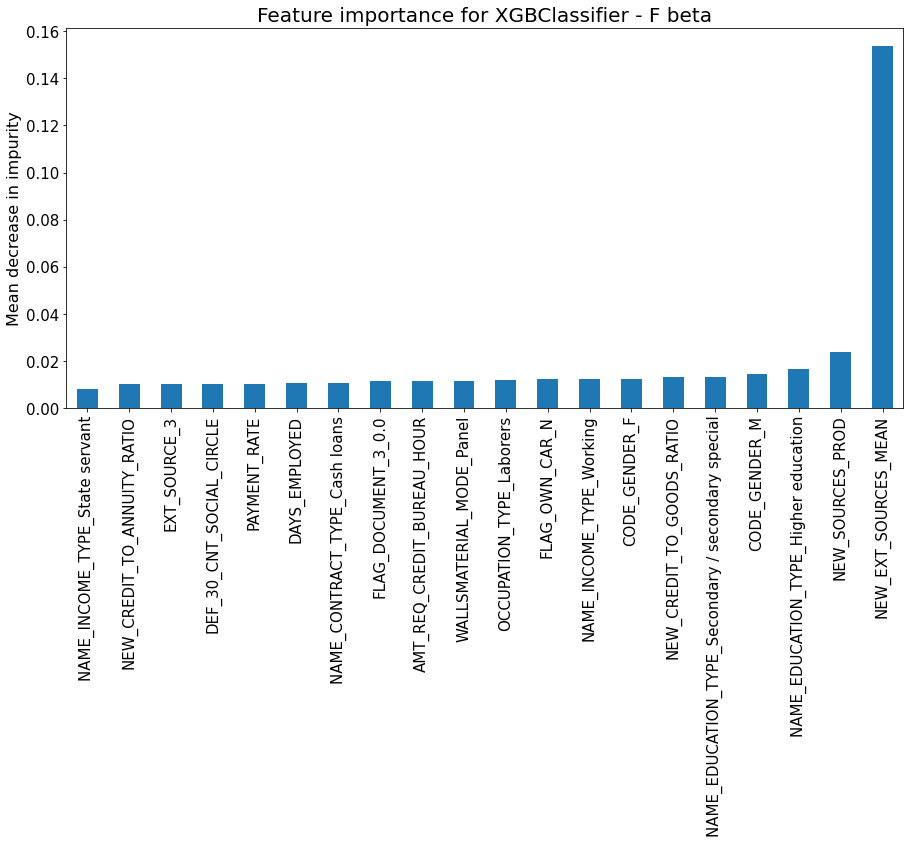

In [92]:
# Features Importances

feature_names = train_df.drop(columns=['SK_ID_CURR', 'TARGET']).columns.to_list()
importances = model.feature_importances_
#std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(15,7))
plot = np.abs(forest_importances).sort_values()[-20:].plot.bar()#yerr=std)
plot.axes.set_title("Feature importance for XGBClassifier - F beta", fontsize = 20)
plot.set_ylabel("Mean decrease in impurity",fontsize=16)
plot.tick_params(labelsize=15)
plt.show()